In [315]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path, errno
import pickle
from glob import glob
import numpy as np
import random
import sys
from tqdm import trange
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
# Get the device
if (torch.cuda.is_available()):
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")



"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

# Data Processing

In [460]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

# # intialize a dataset
city = 'austin' 
split = 'train'

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.2)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.2)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.2):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.2):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
#         tensor = torch.Tensor(self.feature[item])
#         tensorlabel = torch.Tensor(self.label[item])
#         return tensor.to(device), tensorlabel.to(device)

        data = np.concatenate((self.inputs[idx], self.outputs[idx]))
            
        if self.transform:
            data = self.transform(data)

        return torch.Tensor(data).to(device)




# Seq2Seq LSTM Model Implementation

In [494]:
# Credit: Laura Kulowski


class lstm_encoder(nn.Module):
    ''' Encodes time-series sequence '''

    def __init__(self, input_size, hidden_size, num_layers = 1):
        
        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(0.6)

        # define LSTM layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)

    def forward(self, x_input):
        
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence;
        :                              hidden gives the hidden state and cell state for the last
        :                              element in the sequence 
        '''
        
        x_input = self.dropout(x_input)
        lstm_out, self.hidden = self.lstm(x_input.view(x_input.shape[0], x_input.shape[1], self.input_size))
        
        return lstm_out, self.hidden     
    
    def init_hidden(self, batch_size):
        
        '''
        initialize hidden state
        : param batch_size:    x_input.shape[1]
        : return:              zeroed hidden state and cell state 
        '''
        
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))


class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, input_size, hidden_size, num_layers = 1):

        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(0.6)

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        
        '''        
        : param x_input:                    should be 2D (batch_size, input_size)
        : param encoder_hidden_states:      hidden states
        : return output, hidden:            output gives all the hidden states in the sequence;
        :                                   hidden gives the hidden state and cell state for the last
        :                                   element in the sequence 
 
        '''
        
        x_input = self.dropout(x_input)
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(0), encoder_hidden_states)
        output = self.linear(lstm_out.squeeze(0))     
        
        return output, self.hidden

class lstm_seq2seq(nn.Module):
    ''' train LSTM encoder-decoder and make predictions '''
    
    def __init__(self, input_size, hidden_size):

        '''
        : param input_size:     the number of expected features in the input X
        : param hidden_size:    the number of features in the hidden state h
        '''

        super(lstm_seq2seq, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)


    def train_model(self, input_tensor, target_tensor, n_epochs, target_len, batch_size, training_prediction = 'recursive', teacher_forcing_ratio = 0.5, learning_rate = 0.01, dynamic_tf = False):
        
        '''
        train lstm encoder-decoder
        
        : param input_tensor:              input data with shape (seq_len, # in batch, number features); PyTorch tensor    
        : param target_tensor:             target data with shape (seq_len, # in batch, number features); PyTorch tensor
        : param n_epochs:                  number of epochs 
        : param target_len:                number of values to predict 
        : param batch_size:                number of samples per gradient update
        : param training_prediction:       type of prediction to make during training ('recursive', 'teacher_forcing', or
        :                                  'mixed_teacher_forcing'); default is 'recursive'
        : param teacher_forcing_ratio:     float [0, 1) indicating how much teacher forcing to use when
        :                                  training_prediction = 'teacher_forcing.' For each batch in training, we generate a random
        :                                  number. If the random number is less than teacher_forcing_ratio, we use teacher forcing.
        :                                  Otherwise, we predict recursively. If teacher_forcing_ratio = 1, we train only using
        :                                  teacher forcing.
        : param learning_rate:             float >= 0; learning rate
        : param dynamic_tf:                use dynamic teacher forcing (True/False); dynamic teacher forcing
        :                                  reduces the amount of teacher forcing for each epoch
        : return losses:                   array of loss function for each epoch
        '''
        
        # initialize array of losses 
        losses = np.full(n_epochs, np.nan)

        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = nn.MSELoss()

        # calculate number of batch iterations
        n_batches = int(input_tensor.shape[1] / batch_size)

        with trange(n_epochs) as tr:
            for it in tr:
                
                batch_loss = 0.
                batch_loss_tf = 0.
                batch_loss_no_tf = 0.
                num_tf = 0
                num_no_tf = 0

                for b in range(n_batches):
#                     print("at batch: ", b, "/", n_batches)
                    # select data 
                    input_batch = input_tensor[:, b: b + batch_size, :]
                    target_batch = target_tensor[:, b: b + batch_size, :]

                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2]).to(device)

                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)

                    # zero the gradient
                    optimizer.zero_grad()

                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)

                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    if training_prediction == 'recursive':
                        # predict recursively
                        for t in range(target_len): 
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output
                            decoder_input = decoder_output

                    if training_prediction == 'teacher_forcing':
                        # use teacher forcing
                        if random.random() < teacher_forcing_ratio:
                            for t in range(target_len): 
                                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                                outputs[t] = decoder_output
                                decoder_input = target_batch[t, :, :]

                        # predict recursively 
                        else:
                            for t in range(target_len): 
                                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                                outputs[t] = decoder_output
                                decoder_input = decoder_output

                    if training_prediction == 'mixed_teacher_forcing':
                        # predict using mixed teacher forcing
                        for t in range(target_len):
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output
                            
                            # predict with teacher forcing
                            if random.random() < teacher_forcing_ratio:
                                decoder_input = target_batch[t, :, :]
                            
                            # predict recursively 
                            else:
                                decoder_input = decoder_output

                    # compute the loss 
                    loss = criterion(outputs, target_batch)
                    batch_loss += loss.item()
                    
                    # backpropagation
                    loss.backward()
                    optimizer.step()

                # loss for epoch 
                batch_loss /= n_batches 
                losses[it] = batch_loss

                # dynamic teacher forcing
                if dynamic_tf and teacher_forcing_ratio > 0:
                    teacher_forcing_ratio = teacher_forcing_ratio - 0.02 

                # progress bar 
                tr.set_postfix(loss="{0:.3f}".format(batch_loss))
                    
        return losses

    def predict(self, input_tensor, target_len):
        
        '''
        : param input_tensor:      input data (seq_len, input_size); PyTorch tensor 
        : param target_len:        number of target values to predict 
        : return np_outputs:       np.array containing predicted values; prediction done recursively 
        '''

        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1
        encoder_output, encoder_hidden = self.encoder(input_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, input_tensor.shape[2])

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output.squeeze(0)
            decoder_input = decoder_output
            
        np_outputs = outputs.detach().numpy()
        
        return np_outputs

In [495]:
#     takes in the original data array
#     returns the velocity array as (inputVel(x,y), outputVel(x,y)), starting from the 2nd step
def calcVelocity(dataArr):
    dataWV = []
    for path in np.array(dataArr):
        pathWV = []
#         get rid of the initial velocity
#         pathWV.append(path[1] - path[0])
        for coord in range(1, len(path)):
            changePos = path[coord] - path[coord-1]
#             Code for only velocity
            vel = path[coord] - path[coord-1]
            pathWV.append(vel)

#             Position change with actual velocity
#             posWithVel = np.concatenate((changePos, changePos*10))
#             pathWV.append(posWithVel)
    
        dataWV.append(pathWV)
    inp = []
    oup = []
    for path in dataWV:
        inp.append(path[:49])
        oup.append(path[49:])
    return np.array(inp), np.array(oup)

def getVelData(city, split):
    # get train data
    inp, oup = get_city_trajectories(city=city, split=split, normalized=False)
    # get whole path to calculate velocity
    togetherArr = []
    for i in range(len(inp)):
        togetherData = np.concatenate((inp[i], oup[i]))
        togetherArr.append(togetherData)
    inp, oup = calcVelocity(togetherArr)
    return inp, oup

In [449]:
city = 'austin' 
split = 'train'


inputs, outputs = getVelData(city, split)
inpVal, oupVal = getVelData(city, 'val')
    
in_tensor = torch.swapaxes(torch.Tensor(inputs),0,1).to(device)
out_tensor = torch.swapaxes(torch.Tensor(outputs),0,1).to(device)


In [450]:
print(out_tensor.shape)

torch.Size([60, 6456, 2])


In [496]:
# define hyper parameters
learning_rate = 0.0005
epochs = 1200
input_dim = 2
hidden_dim = 512
layer_count = 1
output_dim = 2
batch_size = 256

target_len = 60
training_prediction = 'mixed_teacher_forcing'
teacher_forcing_ratio = 0.5

# specify model parameters and train
model = lstm_seq2seq(input_size = input_dim, hidden_size = hidden_dim).to(device)

100%|██████████████████████████████████████████████████████████████████| 1200/1200 [51:48<00:00,  2.59s/it, loss=0.001]


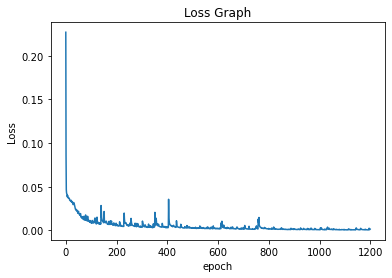

100%|████████████████████████████████████████████████████████████████| 1200/1200 [1:05:51<00:00,  3.29s/it, loss=0.000]


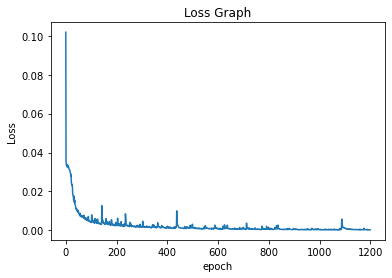

100%|██████████████████████████████████████████████████████████████████| 1200/1200 [53:21<00:00,  2.67s/it, loss=0.000]


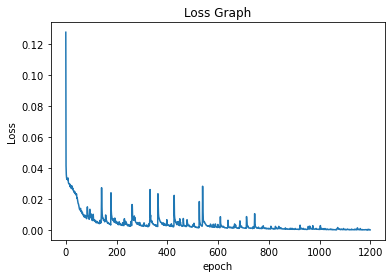

100%|██████████████████████████████████████████████████████████████████| 1200/1200 [29:49<00:00,  1.49s/it, loss=0.001]


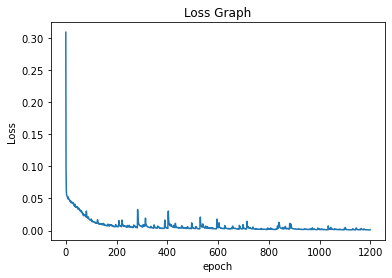

100%|██████████████████████████████████████████████████████████████████| 1200/1200 [31:28<00:00,  1.57s/it, loss=0.001]


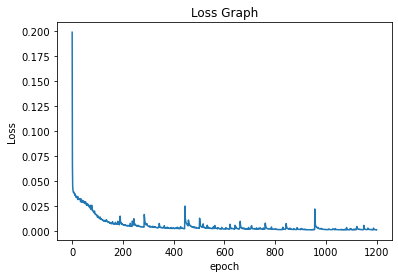

100%|██████████████████████████████████████████████████████████████████| 1200/1200 [14:10<00:00,  1.41it/s, loss=0.003]


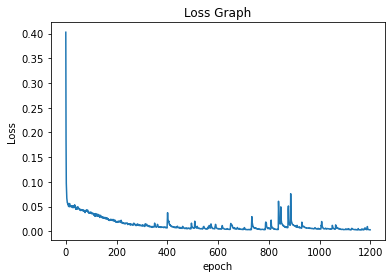

In [497]:
# current Training is with DropOut = 0.6
for cityT in cities:
    trainNSave(cityT, learning_rate, epochs, input_dim, hidden_dim, layer_count, output_dim, batch_size, target_len, training_prediction=training_prediction, teacher_forcing_ratio=teacher_forcing_ratio)

In [464]:
# loss = model.train_model(in_tensor, out_tensor, n_epochs = epochs, target_len = target_len, batch_size = batch_size, training_prediction = training_prediction, teacher_forcing_ratio = teacher_forcing_ratio, learning_rate = learning_rate, dynamic_tf = False)

100%|██████████████████████████████████████████████████████████████████| 1200/1200 [11:47<00:00,  1.70it/s, loss=0.001]


In [471]:
totalacc, mseArr = validate(model, 'austin')

validating,  0 / 34433
validating,  1 / 34433
validating,  2 / 34433
validating,  3 / 34433
validating,  4 / 34433
validating,  5 / 34433
validating,  6 / 34433
validating,  7 / 34433
validating,  8 / 34433
validating,  9 / 34433
validating,  10 / 34433
validating,  11 / 34433
validating,  12 / 34433
validating,  13 / 34433
validating,  14 / 34433
validating,  15 / 34433
validating,  16 / 34433
validating,  17 / 34433
validating,  18 / 34433
validating,  19 / 34433
validating,  20 / 34433
validating,  21 / 34433
validating,  22 / 34433
validating,  23 / 34433
validating,  24 / 34433
validating,  25 / 34433
validating,  26 / 34433
validating,  27 / 34433
validating,  28 / 34433
validating,  29 / 34433
validating,  30 / 34433
validating,  31 / 34433
validating,  32 / 34433
validating,  33 / 34433
validating,  34 / 34433
validating,  35 / 34433
validating,  36 / 34433
validating,  37 / 34433
validating,  38 / 34433
validating,  39 / 34433
validating,  40 / 34433
validating,  41 / 34433
va

validating,  345 / 34433
validating,  346 / 34433
validating,  347 / 34433
validating,  348 / 34433
validating,  349 / 34433
validating,  350 / 34433
validating,  351 / 34433
validating,  352 / 34433
validating,  353 / 34433
validating,  354 / 34433
validating,  355 / 34433
validating,  356 / 34433
validating,  357 / 34433
validating,  358 / 34433
validating,  359 / 34433
validating,  360 / 34433
validating,  361 / 34433
validating,  362 / 34433
validating,  363 / 34433
validating,  364 / 34433
validating,  365 / 34433
validating,  366 / 34433
validating,  367 / 34433
validating,  368 / 34433
validating,  369 / 34433
validating,  370 / 34433
validating,  371 / 34433
validating,  372 / 34433
validating,  373 / 34433
validating,  374 / 34433
validating,  375 / 34433
validating,  376 / 34433
validating,  377 / 34433
validating,  378 / 34433
validating,  379 / 34433
validating,  380 / 34433
validating,  381 / 34433
validating,  382 / 34433
validating,  383 / 34433
validating,  384 / 34433


validating,  683 / 34433
validating,  684 / 34433
validating,  685 / 34433
validating,  686 / 34433
validating,  687 / 34433
validating,  688 / 34433
validating,  689 / 34433
validating,  690 / 34433
validating,  691 / 34433
validating,  692 / 34433
validating,  693 / 34433
validating,  694 / 34433
validating,  695 / 34433
validating,  696 / 34433
validating,  697 / 34433
validating,  698 / 34433
validating,  699 / 34433
validating,  700 / 34433
validating,  701 / 34433
validating,  702 / 34433
validating,  703 / 34433
validating,  704 / 34433
validating,  705 / 34433
validating,  706 / 34433
validating,  707 / 34433
validating,  708 / 34433
validating,  709 / 34433
validating,  710 / 34433
validating,  711 / 34433
validating,  712 / 34433
validating,  713 / 34433
validating,  714 / 34433
validating,  715 / 34433
validating,  716 / 34433
validating,  717 / 34433
validating,  718 / 34433
validating,  719 / 34433
validating,  720 / 34433
validating,  721 / 34433
validating,  722 / 34433


validating,  1017 / 34433
validating,  1018 / 34433
validating,  1019 / 34433
validating,  1020 / 34433
validating,  1021 / 34433
validating,  1022 / 34433
validating,  1023 / 34433
validating,  1024 / 34433
validating,  1025 / 34433
validating,  1026 / 34433
validating,  1027 / 34433
validating,  1028 / 34433
validating,  1029 / 34433
validating,  1030 / 34433
validating,  1031 / 34433
validating,  1032 / 34433
validating,  1033 / 34433
validating,  1034 / 34433
validating,  1035 / 34433
validating,  1036 / 34433
validating,  1037 / 34433
validating,  1038 / 34433
validating,  1039 / 34433
validating,  1040 / 34433
validating,  1041 / 34433
validating,  1042 / 34433
validating,  1043 / 34433
validating,  1044 / 34433
validating,  1045 / 34433
validating,  1046 / 34433
validating,  1047 / 34433
validating,  1048 / 34433
validating,  1049 / 34433
validating,  1050 / 34433
validating,  1051 / 34433
validating,  1052 / 34433
validating,  1053 / 34433
validating,  1054 / 34433
validating, 

validating,  1337 / 34433
validating,  1338 / 34433
validating,  1339 / 34433
validating,  1340 / 34433
validating,  1341 / 34433
validating,  1342 / 34433
validating,  1343 / 34433
validating,  1344 / 34433
validating,  1345 / 34433
validating,  1346 / 34433
validating,  1347 / 34433
validating,  1348 / 34433
validating,  1349 / 34433
validating,  1350 / 34433
validating,  1351 / 34433
validating,  1352 / 34433
validating,  1353 / 34433
validating,  1354 / 34433
validating,  1355 / 34433
validating,  1356 / 34433
validating,  1357 / 34433
validating,  1358 / 34433
validating,  1359 / 34433
validating,  1360 / 34433
validating,  1361 / 34433
validating,  1362 / 34433
validating,  1363 / 34433
validating,  1364 / 34433
validating,  1365 / 34433
validating,  1366 / 34433
validating,  1367 / 34433
validating,  1368 / 34433
validating,  1369 / 34433
validating,  1370 / 34433
validating,  1371 / 34433
validating,  1372 / 34433
validating,  1373 / 34433
validating,  1374 / 34433
validating, 

validating,  1656 / 34433
validating,  1657 / 34433
validating,  1658 / 34433
validating,  1659 / 34433
validating,  1660 / 34433
validating,  1661 / 34433
validating,  1662 / 34433
validating,  1663 / 34433
validating,  1664 / 34433
validating,  1665 / 34433
validating,  1666 / 34433
validating,  1667 / 34433
validating,  1668 / 34433
validating,  1669 / 34433
validating,  1670 / 34433
validating,  1671 / 34433
validating,  1672 / 34433
validating,  1673 / 34433
validating,  1674 / 34433
validating,  1675 / 34433
validating,  1676 / 34433
validating,  1677 / 34433
validating,  1678 / 34433
validating,  1679 / 34433
validating,  1680 / 34433
validating,  1681 / 34433
validating,  1682 / 34433
validating,  1683 / 34433
validating,  1684 / 34433
validating,  1685 / 34433
validating,  1686 / 34433
validating,  1687 / 34433
validating,  1688 / 34433
validating,  1689 / 34433
validating,  1690 / 34433
validating,  1691 / 34433
validating,  1692 / 34433
validating,  1693 / 34433
validating, 

validating,  1982 / 34433
validating,  1983 / 34433
validating,  1984 / 34433
validating,  1985 / 34433
validating,  1986 / 34433
validating,  1987 / 34433
validating,  1988 / 34433
validating,  1989 / 34433
validating,  1990 / 34433
validating,  1991 / 34433
validating,  1992 / 34433
validating,  1993 / 34433
validating,  1994 / 34433
validating,  1995 / 34433
validating,  1996 / 34433
validating,  1997 / 34433
validating,  1998 / 34433
validating,  1999 / 34433
validating,  2000 / 34433
validating,  2001 / 34433
validating,  2002 / 34433
validating,  2003 / 34433
validating,  2004 / 34433
validating,  2005 / 34433
validating,  2006 / 34433
validating,  2007 / 34433
validating,  2008 / 34433
validating,  2009 / 34433
validating,  2010 / 34433
validating,  2011 / 34433
validating,  2012 / 34433
validating,  2013 / 34433
validating,  2014 / 34433
validating,  2015 / 34433
validating,  2016 / 34433
validating,  2017 / 34433
validating,  2018 / 34433
validating,  2019 / 34433
validating, 

validating,  2306 / 34433
validating,  2307 / 34433
validating,  2308 / 34433
validating,  2309 / 34433
validating,  2310 / 34433
validating,  2311 / 34433
validating,  2312 / 34433
validating,  2313 / 34433
validating,  2314 / 34433
validating,  2315 / 34433
validating,  2316 / 34433
validating,  2317 / 34433
validating,  2318 / 34433
validating,  2319 / 34433
validating,  2320 / 34433
validating,  2321 / 34433
validating,  2322 / 34433
validating,  2323 / 34433
validating,  2324 / 34433
validating,  2325 / 34433
validating,  2326 / 34433
validating,  2327 / 34433
validating,  2328 / 34433
validating,  2329 / 34433
validating,  2330 / 34433
validating,  2331 / 34433
validating,  2332 / 34433
validating,  2333 / 34433
validating,  2334 / 34433
validating,  2335 / 34433
validating,  2336 / 34433
validating,  2337 / 34433
validating,  2338 / 34433
validating,  2339 / 34433
validating,  2340 / 34433
validating,  2341 / 34433
validating,  2342 / 34433
validating,  2343 / 34433
validating, 

validating,  2623 / 34433
validating,  2624 / 34433
validating,  2625 / 34433
validating,  2626 / 34433
validating,  2627 / 34433
validating,  2628 / 34433
validating,  2629 / 34433
validating,  2630 / 34433
validating,  2631 / 34433
validating,  2632 / 34433
validating,  2633 / 34433
validating,  2634 / 34433
validating,  2635 / 34433
validating,  2636 / 34433
validating,  2637 / 34433
validating,  2638 / 34433
validating,  2639 / 34433
validating,  2640 / 34433
validating,  2641 / 34433
validating,  2642 / 34433
validating,  2643 / 34433
validating,  2644 / 34433
validating,  2645 / 34433
validating,  2646 / 34433
validating,  2647 / 34433
validating,  2648 / 34433
validating,  2649 / 34433
validating,  2650 / 34433
validating,  2651 / 34433
validating,  2652 / 34433
validating,  2653 / 34433
validating,  2654 / 34433
validating,  2655 / 34433
validating,  2656 / 34433
validating,  2657 / 34433
validating,  2658 / 34433
validating,  2659 / 34433
validating,  2660 / 34433
validating, 

validating,  2945 / 34433
validating,  2946 / 34433
validating,  2947 / 34433
validating,  2948 / 34433
validating,  2949 / 34433
validating,  2950 / 34433
validating,  2951 / 34433
validating,  2952 / 34433
validating,  2953 / 34433
validating,  2954 / 34433
validating,  2955 / 34433
validating,  2956 / 34433
validating,  2957 / 34433
validating,  2958 / 34433
validating,  2959 / 34433
validating,  2960 / 34433
validating,  2961 / 34433
validating,  2962 / 34433
validating,  2963 / 34433
validating,  2964 / 34433
validating,  2965 / 34433
validating,  2966 / 34433
validating,  2967 / 34433
validating,  2968 / 34433
validating,  2969 / 34433
validating,  2970 / 34433
validating,  2971 / 34433
validating,  2972 / 34433
validating,  2973 / 34433
validating,  2974 / 34433
validating,  2975 / 34433
validating,  2976 / 34433
validating,  2977 / 34433
validating,  2978 / 34433
validating,  2979 / 34433
validating,  2980 / 34433
validating,  2981 / 34433
validating,  2982 / 34433
validating, 

validating,  3269 / 34433
validating,  3270 / 34433
validating,  3271 / 34433
validating,  3272 / 34433
validating,  3273 / 34433
validating,  3274 / 34433
validating,  3275 / 34433
validating,  3276 / 34433
validating,  3277 / 34433
validating,  3278 / 34433
validating,  3279 / 34433
validating,  3280 / 34433
validating,  3281 / 34433
validating,  3282 / 34433
validating,  3283 / 34433
validating,  3284 / 34433
validating,  3285 / 34433
validating,  3286 / 34433
validating,  3287 / 34433
validating,  3288 / 34433
validating,  3289 / 34433
validating,  3290 / 34433
validating,  3291 / 34433
validating,  3292 / 34433
validating,  3293 / 34433
validating,  3294 / 34433
validating,  3295 / 34433
validating,  3296 / 34433
validating,  3297 / 34433
validating,  3298 / 34433
validating,  3299 / 34433
validating,  3300 / 34433
validating,  3301 / 34433
validating,  3302 / 34433
validating,  3303 / 34433
validating,  3304 / 34433
validating,  3305 / 34433
validating,  3306 / 34433
validating, 

validating,  3590 / 34433
validating,  3591 / 34433
validating,  3592 / 34433
validating,  3593 / 34433
validating,  3594 / 34433
validating,  3595 / 34433
validating,  3596 / 34433
validating,  3597 / 34433
validating,  3598 / 34433
validating,  3599 / 34433
validating,  3600 / 34433
validating,  3601 / 34433
validating,  3602 / 34433
validating,  3603 / 34433
validating,  3604 / 34433
validating,  3605 / 34433
validating,  3606 / 34433
validating,  3607 / 34433
validating,  3608 / 34433
validating,  3609 / 34433
validating,  3610 / 34433
validating,  3611 / 34433
validating,  3612 / 34433
validating,  3613 / 34433
validating,  3614 / 34433
validating,  3615 / 34433
validating,  3616 / 34433
validating,  3617 / 34433
validating,  3618 / 34433
validating,  3619 / 34433
validating,  3620 / 34433
validating,  3621 / 34433
validating,  3622 / 34433
validating,  3623 / 34433
validating,  3624 / 34433
validating,  3625 / 34433
validating,  3626 / 34433
validating,  3627 / 34433
validating, 

validating,  3916 / 34433
validating,  3917 / 34433
validating,  3918 / 34433
validating,  3919 / 34433
validating,  3920 / 34433
validating,  3921 / 34433
validating,  3922 / 34433
validating,  3923 / 34433
validating,  3924 / 34433
validating,  3925 / 34433
validating,  3926 / 34433
validating,  3927 / 34433
validating,  3928 / 34433
validating,  3929 / 34433
validating,  3930 / 34433
validating,  3931 / 34433
validating,  3932 / 34433
validating,  3933 / 34433
validating,  3934 / 34433
validating,  3935 / 34433
validating,  3936 / 34433
validating,  3937 / 34433
validating,  3938 / 34433
validating,  3939 / 34433
validating,  3940 / 34433
validating,  3941 / 34433
validating,  3942 / 34433
validating,  3943 / 34433
validating,  3944 / 34433
validating,  3945 / 34433
validating,  3946 / 34433
validating,  3947 / 34433
validating,  3948 / 34433
validating,  3949 / 34433
validating,  3950 / 34433
validating,  3951 / 34433
validating,  3952 / 34433
validating,  3953 / 34433
validating, 

validating,  4244 / 34433
validating,  4245 / 34433
validating,  4246 / 34433
validating,  4247 / 34433
validating,  4248 / 34433
validating,  4249 / 34433
validating,  4250 / 34433
validating,  4251 / 34433
validating,  4252 / 34433
validating,  4253 / 34433
validating,  4254 / 34433
validating,  4255 / 34433
validating,  4256 / 34433
validating,  4257 / 34433
validating,  4258 / 34433
validating,  4259 / 34433
validating,  4260 / 34433
validating,  4261 / 34433
validating,  4262 / 34433
validating,  4263 / 34433
validating,  4264 / 34433
validating,  4265 / 34433
validating,  4266 / 34433
validating,  4267 / 34433
validating,  4268 / 34433
validating,  4269 / 34433
validating,  4270 / 34433
validating,  4271 / 34433
validating,  4272 / 34433
validating,  4273 / 34433
validating,  4274 / 34433
validating,  4275 / 34433
validating,  4276 / 34433
validating,  4277 / 34433
validating,  4278 / 34433
validating,  4279 / 34433
validating,  4280 / 34433
validating,  4281 / 34433
validating, 

validating,  4565 / 34433
validating,  4566 / 34433
validating,  4567 / 34433
validating,  4568 / 34433
validating,  4569 / 34433
validating,  4570 / 34433
validating,  4571 / 34433
validating,  4572 / 34433
validating,  4573 / 34433
validating,  4574 / 34433
validating,  4575 / 34433
validating,  4576 / 34433
validating,  4577 / 34433
validating,  4578 / 34433
validating,  4579 / 34433
validating,  4580 / 34433
validating,  4581 / 34433
validating,  4582 / 34433
validating,  4583 / 34433
validating,  4584 / 34433
validating,  4585 / 34433
validating,  4586 / 34433
validating,  4587 / 34433
validating,  4588 / 34433
validating,  4589 / 34433
validating,  4590 / 34433
validating,  4591 / 34433
validating,  4592 / 34433
validating,  4593 / 34433
validating,  4594 / 34433
validating,  4595 / 34433
validating,  4596 / 34433
validating,  4597 / 34433
validating,  4598 / 34433
validating,  4599 / 34433
validating,  4600 / 34433
validating,  4601 / 34433
validating,  4602 / 34433
validating, 

validating,  4884 / 34433
validating,  4885 / 34433
validating,  4886 / 34433
validating,  4887 / 34433
validating,  4888 / 34433
validating,  4889 / 34433
validating,  4890 / 34433
validating,  4891 / 34433
validating,  4892 / 34433
validating,  4893 / 34433
validating,  4894 / 34433
validating,  4895 / 34433
validating,  4896 / 34433
validating,  4897 / 34433
validating,  4898 / 34433
validating,  4899 / 34433
validating,  4900 / 34433
validating,  4901 / 34433
validating,  4902 / 34433
validating,  4903 / 34433
validating,  4904 / 34433
validating,  4905 / 34433
validating,  4906 / 34433
validating,  4907 / 34433
validating,  4908 / 34433
validating,  4909 / 34433
validating,  4910 / 34433
validating,  4911 / 34433
validating,  4912 / 34433
validating,  4913 / 34433
validating,  4914 / 34433
validating,  4915 / 34433
validating,  4916 / 34433
validating,  4917 / 34433
validating,  4918 / 34433
validating,  4919 / 34433
validating,  4920 / 34433
validating,  4921 / 34433
validating, 

validating,  5203 / 34433
validating,  5204 / 34433
validating,  5205 / 34433
validating,  5206 / 34433
validating,  5207 / 34433
validating,  5208 / 34433
validating,  5209 / 34433
validating,  5210 / 34433
validating,  5211 / 34433
validating,  5212 / 34433
validating,  5213 / 34433
validating,  5214 / 34433
validating,  5215 / 34433
validating,  5216 / 34433
validating,  5217 / 34433
validating,  5218 / 34433
validating,  5219 / 34433
validating,  5220 / 34433
validating,  5221 / 34433
validating,  5222 / 34433
validating,  5223 / 34433
validating,  5224 / 34433
validating,  5225 / 34433
validating,  5226 / 34433
validating,  5227 / 34433
validating,  5228 / 34433
validating,  5229 / 34433
validating,  5230 / 34433
validating,  5231 / 34433
validating,  5232 / 34433
validating,  5233 / 34433
validating,  5234 / 34433
validating,  5235 / 34433
validating,  5236 / 34433
validating,  5237 / 34433
validating,  5238 / 34433
validating,  5239 / 34433
validating,  5240 / 34433
validating, 

validating,  5526 / 34433
validating,  5527 / 34433
validating,  5528 / 34433
validating,  5529 / 34433
validating,  5530 / 34433
validating,  5531 / 34433
validating,  5532 / 34433
validating,  5533 / 34433
validating,  5534 / 34433
validating,  5535 / 34433
validating,  5536 / 34433
validating,  5537 / 34433
validating,  5538 / 34433
validating,  5539 / 34433
validating,  5540 / 34433
validating,  5541 / 34433
validating,  5542 / 34433
validating,  5543 / 34433
validating,  5544 / 34433
validating,  5545 / 34433
validating,  5546 / 34433
validating,  5547 / 34433
validating,  5548 / 34433
validating,  5549 / 34433
validating,  5550 / 34433
validating,  5551 / 34433
validating,  5552 / 34433
validating,  5553 / 34433
validating,  5554 / 34433
validating,  5555 / 34433
validating,  5556 / 34433
validating,  5557 / 34433
validating,  5558 / 34433
validating,  5559 / 34433
validating,  5560 / 34433
validating,  5561 / 34433
validating,  5562 / 34433
validating,  5563 / 34433
validating, 

validating,  5849 / 34433
validating,  5850 / 34433
validating,  5851 / 34433
validating,  5852 / 34433
validating,  5853 / 34433
validating,  5854 / 34433
validating,  5855 / 34433
validating,  5856 / 34433
validating,  5857 / 34433
validating,  5858 / 34433
validating,  5859 / 34433
validating,  5860 / 34433
validating,  5861 / 34433
validating,  5862 / 34433
validating,  5863 / 34433
validating,  5864 / 34433
validating,  5865 / 34433
validating,  5866 / 34433
validating,  5867 / 34433
validating,  5868 / 34433
validating,  5869 / 34433
validating,  5870 / 34433
validating,  5871 / 34433
validating,  5872 / 34433
validating,  5873 / 34433
validating,  5874 / 34433
validating,  5875 / 34433
validating,  5876 / 34433
validating,  5877 / 34433
validating,  5878 / 34433
validating,  5879 / 34433
validating,  5880 / 34433
validating,  5881 / 34433
validating,  5882 / 34433
validating,  5883 / 34433
validating,  5884 / 34433
validating,  5885 / 34433
validating,  5886 / 34433
validating, 

validating,  6174 / 34433
validating,  6175 / 34433
validating,  6176 / 34433
validating,  6177 / 34433
validating,  6178 / 34433
validating,  6179 / 34433
validating,  6180 / 34433
validating,  6181 / 34433
validating,  6182 / 34433
validating,  6183 / 34433
validating,  6184 / 34433
validating,  6185 / 34433
validating,  6186 / 34433
validating,  6187 / 34433
validating,  6188 / 34433
validating,  6189 / 34433
validating,  6190 / 34433
validating,  6191 / 34433
validating,  6192 / 34433
validating,  6193 / 34433
validating,  6194 / 34433
validating,  6195 / 34433
validating,  6196 / 34433
validating,  6197 / 34433
validating,  6198 / 34433
validating,  6199 / 34433
validating,  6200 / 34433
validating,  6201 / 34433
validating,  6202 / 34433
validating,  6203 / 34433
validating,  6204 / 34433
validating,  6205 / 34433
validating,  6206 / 34433
validating,  6207 / 34433
validating,  6208 / 34433
validating,  6209 / 34433
validating,  6210 / 34433
validating,  6211 / 34433
validating, 

validating,  6496 / 34433
validating,  6497 / 34433
validating,  6498 / 34433
validating,  6499 / 34433
validating,  6500 / 34433
validating,  6501 / 34433
validating,  6502 / 34433
validating,  6503 / 34433
validating,  6504 / 34433
validating,  6505 / 34433
validating,  6506 / 34433
validating,  6507 / 34433
validating,  6508 / 34433
validating,  6509 / 34433
validating,  6510 / 34433
validating,  6511 / 34433
validating,  6512 / 34433
validating,  6513 / 34433
validating,  6514 / 34433
validating,  6515 / 34433
validating,  6516 / 34433
validating,  6517 / 34433
validating,  6518 / 34433
validating,  6519 / 34433
validating,  6520 / 34433
validating,  6521 / 34433
validating,  6522 / 34433
validating,  6523 / 34433
validating,  6524 / 34433
validating,  6525 / 34433
validating,  6526 / 34433
validating,  6527 / 34433
validating,  6528 / 34433
validating,  6529 / 34433
validating,  6530 / 34433
validating,  6531 / 34433
validating,  6532 / 34433
validating,  6533 / 34433
validating, 

validating,  6817 / 34433
validating,  6818 / 34433
validating,  6819 / 34433
validating,  6820 / 34433
validating,  6821 / 34433
validating,  6822 / 34433
validating,  6823 / 34433
validating,  6824 / 34433
validating,  6825 / 34433
validating,  6826 / 34433
validating,  6827 / 34433
validating,  6828 / 34433
validating,  6829 / 34433
validating,  6830 / 34433
validating,  6831 / 34433
validating,  6832 / 34433
validating,  6833 / 34433
validating,  6834 / 34433
validating,  6835 / 34433
validating,  6836 / 34433
validating,  6837 / 34433
validating,  6838 / 34433
validating,  6839 / 34433
validating,  6840 / 34433
validating,  6841 / 34433
validating,  6842 / 34433
validating,  6843 / 34433
validating,  6844 / 34433
validating,  6845 / 34433
validating,  6846 / 34433
validating,  6847 / 34433
validating,  6848 / 34433
validating,  6849 / 34433
validating,  6850 / 34433
validating,  6851 / 34433
validating,  6852 / 34433
validating,  6853 / 34433
validating,  6854 / 34433
validating, 

validating,  7137 / 34433
validating,  7138 / 34433
validating,  7139 / 34433
validating,  7140 / 34433
validating,  7141 / 34433
validating,  7142 / 34433
validating,  7143 / 34433
validating,  7144 / 34433
validating,  7145 / 34433
validating,  7146 / 34433
validating,  7147 / 34433
validating,  7148 / 34433
validating,  7149 / 34433
validating,  7150 / 34433
validating,  7151 / 34433
validating,  7152 / 34433
validating,  7153 / 34433
validating,  7154 / 34433
validating,  7155 / 34433
validating,  7156 / 34433
validating,  7157 / 34433
validating,  7158 / 34433
validating,  7159 / 34433
validating,  7160 / 34433
validating,  7161 / 34433
validating,  7162 / 34433
validating,  7163 / 34433
validating,  7164 / 34433
validating,  7165 / 34433
validating,  7166 / 34433
validating,  7167 / 34433
validating,  7168 / 34433
validating,  7169 / 34433
validating,  7170 / 34433
validating,  7171 / 34433
validating,  7172 / 34433
validating,  7173 / 34433
validating,  7174 / 34433
validating, 

validating,  7464 / 34433
validating,  7465 / 34433
validating,  7466 / 34433
validating,  7467 / 34433
validating,  7468 / 34433
validating,  7469 / 34433
validating,  7470 / 34433
validating,  7471 / 34433
validating,  7472 / 34433
validating,  7473 / 34433
validating,  7474 / 34433
validating,  7475 / 34433
validating,  7476 / 34433
validating,  7477 / 34433
validating,  7478 / 34433
validating,  7479 / 34433
validating,  7480 / 34433
validating,  7481 / 34433
validating,  7482 / 34433
validating,  7483 / 34433
validating,  7484 / 34433
validating,  7485 / 34433
validating,  7486 / 34433
validating,  7487 / 34433
validating,  7488 / 34433
validating,  7489 / 34433
validating,  7490 / 34433
validating,  7491 / 34433
validating,  7492 / 34433
validating,  7493 / 34433
validating,  7494 / 34433
validating,  7495 / 34433
validating,  7496 / 34433
validating,  7497 / 34433
validating,  7498 / 34433
validating,  7499 / 34433
validating,  7500 / 34433
validating,  7501 / 34433
validating, 

validating,  7784 / 34433
validating,  7785 / 34433
validating,  7786 / 34433
validating,  7787 / 34433
validating,  7788 / 34433
validating,  7789 / 34433
validating,  7790 / 34433
validating,  7791 / 34433
validating,  7792 / 34433
validating,  7793 / 34433
validating,  7794 / 34433
validating,  7795 / 34433
validating,  7796 / 34433
validating,  7797 / 34433
validating,  7798 / 34433
validating,  7799 / 34433
validating,  7800 / 34433
validating,  7801 / 34433
validating,  7802 / 34433
validating,  7803 / 34433
validating,  7804 / 34433
validating,  7805 / 34433
validating,  7806 / 34433
validating,  7807 / 34433
validating,  7808 / 34433
validating,  7809 / 34433
validating,  7810 / 34433
validating,  7811 / 34433
validating,  7812 / 34433
validating,  7813 / 34433
validating,  7814 / 34433
validating,  7815 / 34433
validating,  7816 / 34433
validating,  7817 / 34433
validating,  7818 / 34433
validating,  7819 / 34433
validating,  7820 / 34433
validating,  7821 / 34433
validating, 

validating,  8108 / 34433
validating,  8109 / 34433
validating,  8110 / 34433
validating,  8111 / 34433
validating,  8112 / 34433
validating,  8113 / 34433
validating,  8114 / 34433
validating,  8115 / 34433
validating,  8116 / 34433
validating,  8117 / 34433
validating,  8118 / 34433
validating,  8119 / 34433
validating,  8120 / 34433
validating,  8121 / 34433
validating,  8122 / 34433
validating,  8123 / 34433
validating,  8124 / 34433
validating,  8125 / 34433
validating,  8126 / 34433
validating,  8127 / 34433
validating,  8128 / 34433
validating,  8129 / 34433
validating,  8130 / 34433
validating,  8131 / 34433
validating,  8132 / 34433
validating,  8133 / 34433
validating,  8134 / 34433
validating,  8135 / 34433
validating,  8136 / 34433
validating,  8137 / 34433
validating,  8138 / 34433
validating,  8139 / 34433
validating,  8140 / 34433
validating,  8141 / 34433
validating,  8142 / 34433
validating,  8143 / 34433
validating,  8144 / 34433
validating,  8145 / 34433
validating, 

validating,  8432 / 34433
validating,  8433 / 34433
validating,  8434 / 34433
validating,  8435 / 34433
validating,  8436 / 34433
validating,  8437 / 34433
validating,  8438 / 34433
validating,  8439 / 34433
validating,  8440 / 34433
validating,  8441 / 34433
validating,  8442 / 34433
validating,  8443 / 34433
validating,  8444 / 34433
validating,  8445 / 34433
validating,  8446 / 34433
validating,  8447 / 34433
validating,  8448 / 34433
validating,  8449 / 34433
validating,  8450 / 34433
validating,  8451 / 34433
validating,  8452 / 34433
validating,  8453 / 34433
validating,  8454 / 34433
validating,  8455 / 34433
validating,  8456 / 34433
validating,  8457 / 34433
validating,  8458 / 34433
validating,  8459 / 34433
validating,  8460 / 34433
validating,  8461 / 34433
validating,  8462 / 34433
validating,  8463 / 34433
validating,  8464 / 34433
validating,  8465 / 34433
validating,  8466 / 34433
validating,  8467 / 34433
validating,  8468 / 34433
validating,  8469 / 34433
validating, 

validating,  8752 / 34433
validating,  8753 / 34433
validating,  8754 / 34433
validating,  8755 / 34433
validating,  8756 / 34433
validating,  8757 / 34433
validating,  8758 / 34433
validating,  8759 / 34433
validating,  8760 / 34433
validating,  8761 / 34433
validating,  8762 / 34433
validating,  8763 / 34433
validating,  8764 / 34433
validating,  8765 / 34433
validating,  8766 / 34433
validating,  8767 / 34433
validating,  8768 / 34433
validating,  8769 / 34433
validating,  8770 / 34433
validating,  8771 / 34433
validating,  8772 / 34433
validating,  8773 / 34433
validating,  8774 / 34433
validating,  8775 / 34433
validating,  8776 / 34433
validating,  8777 / 34433
validating,  8778 / 34433
validating,  8779 / 34433
validating,  8780 / 34433
validating,  8781 / 34433
validating,  8782 / 34433
validating,  8783 / 34433
validating,  8784 / 34433
validating,  8785 / 34433
validating,  8786 / 34433
validating,  8787 / 34433
validating,  8788 / 34433
validating,  8789 / 34433
validating, 

validating,  9072 / 34433
validating,  9073 / 34433
validating,  9074 / 34433
validating,  9075 / 34433
validating,  9076 / 34433
validating,  9077 / 34433
validating,  9078 / 34433
validating,  9079 / 34433
validating,  9080 / 34433
validating,  9081 / 34433
validating,  9082 / 34433
validating,  9083 / 34433
validating,  9084 / 34433
validating,  9085 / 34433
validating,  9086 / 34433
validating,  9087 / 34433
validating,  9088 / 34433
validating,  9089 / 34433
validating,  9090 / 34433
validating,  9091 / 34433
validating,  9092 / 34433
validating,  9093 / 34433
validating,  9094 / 34433
validating,  9095 / 34433
validating,  9096 / 34433
validating,  9097 / 34433
validating,  9098 / 34433
validating,  9099 / 34433
validating,  9100 / 34433
validating,  9101 / 34433
validating,  9102 / 34433
validating,  9103 / 34433
validating,  9104 / 34433
validating,  9105 / 34433
validating,  9106 / 34433
validating,  9107 / 34433
validating,  9108 / 34433
validating,  9109 / 34433
validating, 

validating,  9394 / 34433
validating,  9395 / 34433
validating,  9396 / 34433
validating,  9397 / 34433
validating,  9398 / 34433
validating,  9399 / 34433
validating,  9400 / 34433
validating,  9401 / 34433
validating,  9402 / 34433
validating,  9403 / 34433
validating,  9404 / 34433
validating,  9405 / 34433
validating,  9406 / 34433
validating,  9407 / 34433
validating,  9408 / 34433
validating,  9409 / 34433
validating,  9410 / 34433
validating,  9411 / 34433
validating,  9412 / 34433
validating,  9413 / 34433
validating,  9414 / 34433
validating,  9415 / 34433
validating,  9416 / 34433
validating,  9417 / 34433
validating,  9418 / 34433
validating,  9419 / 34433
validating,  9420 / 34433
validating,  9421 / 34433
validating,  9422 / 34433
validating,  9423 / 34433
validating,  9424 / 34433
validating,  9425 / 34433
validating,  9426 / 34433
validating,  9427 / 34433
validating,  9428 / 34433
validating,  9429 / 34433
validating,  9430 / 34433
validating,  9431 / 34433
validating, 

validating,  9717 / 34433
validating,  9718 / 34433
validating,  9719 / 34433
validating,  9720 / 34433
validating,  9721 / 34433
validating,  9722 / 34433
validating,  9723 / 34433
validating,  9724 / 34433
validating,  9725 / 34433
validating,  9726 / 34433
validating,  9727 / 34433
validating,  9728 / 34433
validating,  9729 / 34433
validating,  9730 / 34433
validating,  9731 / 34433
validating,  9732 / 34433
validating,  9733 / 34433
validating,  9734 / 34433
validating,  9735 / 34433
validating,  9736 / 34433
validating,  9737 / 34433
validating,  9738 / 34433
validating,  9739 / 34433
validating,  9740 / 34433
validating,  9741 / 34433
validating,  9742 / 34433
validating,  9743 / 34433
validating,  9744 / 34433
validating,  9745 / 34433
validating,  9746 / 34433
validating,  9747 / 34433
validating,  9748 / 34433
validating,  9749 / 34433
validating,  9750 / 34433
validating,  9751 / 34433
validating,  9752 / 34433
validating,  9753 / 34433
validating,  9754 / 34433
validating, 

validating,  10043 / 34433
validating,  10044 / 34433
validating,  10045 / 34433
validating,  10046 / 34433
validating,  10047 / 34433
validating,  10048 / 34433
validating,  10049 / 34433
validating,  10050 / 34433
validating,  10051 / 34433
validating,  10052 / 34433
validating,  10053 / 34433
validating,  10054 / 34433
validating,  10055 / 34433
validating,  10056 / 34433
validating,  10057 / 34433
validating,  10058 / 34433
validating,  10059 / 34433
validating,  10060 / 34433
validating,  10061 / 34433
validating,  10062 / 34433
validating,  10063 / 34433
validating,  10064 / 34433
validating,  10065 / 34433
validating,  10066 / 34433
validating,  10067 / 34433
validating,  10068 / 34433
validating,  10069 / 34433
validating,  10070 / 34433
validating,  10071 / 34433
validating,  10072 / 34433
validating,  10073 / 34433
validating,  10074 / 34433
validating,  10075 / 34433
validating,  10076 / 34433
validating,  10077 / 34433
validating,  10078 / 34433
validating,  10079 / 34433
v

validating,  10349 / 34433
validating,  10350 / 34433
validating,  10351 / 34433
validating,  10352 / 34433
validating,  10353 / 34433
validating,  10354 / 34433
validating,  10355 / 34433
validating,  10356 / 34433
validating,  10357 / 34433
validating,  10358 / 34433
validating,  10359 / 34433
validating,  10360 / 34433
validating,  10361 / 34433
validating,  10362 / 34433
validating,  10363 / 34433
validating,  10364 / 34433
validating,  10365 / 34433
validating,  10366 / 34433
validating,  10367 / 34433
validating,  10368 / 34433
validating,  10369 / 34433
validating,  10370 / 34433
validating,  10371 / 34433
validating,  10372 / 34433
validating,  10373 / 34433
validating,  10374 / 34433
validating,  10375 / 34433
validating,  10376 / 34433
validating,  10377 / 34433
validating,  10378 / 34433
validating,  10379 / 34433
validating,  10380 / 34433
validating,  10381 / 34433
validating,  10382 / 34433
validating,  10383 / 34433
validating,  10384 / 34433
validating,  10385 / 34433
v

validating,  10656 / 34433
validating,  10657 / 34433
validating,  10658 / 34433
validating,  10659 / 34433
validating,  10660 / 34433
validating,  10661 / 34433
validating,  10662 / 34433
validating,  10663 / 34433
validating,  10664 / 34433
validating,  10665 / 34433
validating,  10666 / 34433
validating,  10667 / 34433
validating,  10668 / 34433
validating,  10669 / 34433
validating,  10670 / 34433
validating,  10671 / 34433
validating,  10672 / 34433
validating,  10673 / 34433
validating,  10674 / 34433
validating,  10675 / 34433
validating,  10676 / 34433
validating,  10677 / 34433
validating,  10678 / 34433
validating,  10679 / 34433
validating,  10680 / 34433
validating,  10681 / 34433
validating,  10682 / 34433
validating,  10683 / 34433
validating,  10684 / 34433
validating,  10685 / 34433
validating,  10686 / 34433
validating,  10687 / 34433
validating,  10688 / 34433
validating,  10689 / 34433
validating,  10690 / 34433
validating,  10691 / 34433
validating,  10692 / 34433
v

validating,  10975 / 34433
validating,  10976 / 34433
validating,  10977 / 34433
validating,  10978 / 34433
validating,  10979 / 34433
validating,  10980 / 34433
validating,  10981 / 34433
validating,  10982 / 34433
validating,  10983 / 34433
validating,  10984 / 34433
validating,  10985 / 34433
validating,  10986 / 34433
validating,  10987 / 34433
validating,  10988 / 34433
validating,  10989 / 34433
validating,  10990 / 34433
validating,  10991 / 34433
validating,  10992 / 34433
validating,  10993 / 34433
validating,  10994 / 34433
validating,  10995 / 34433
validating,  10996 / 34433
validating,  10997 / 34433
validating,  10998 / 34433
validating,  10999 / 34433
validating,  11000 / 34433
validating,  11001 / 34433
validating,  11002 / 34433
validating,  11003 / 34433
validating,  11004 / 34433
validating,  11005 / 34433
validating,  11006 / 34433
validating,  11007 / 34433
validating,  11008 / 34433
validating,  11009 / 34433
validating,  11010 / 34433
validating,  11011 / 34433
v

validating,  11281 / 34433
validating,  11282 / 34433
validating,  11283 / 34433
validating,  11284 / 34433
validating,  11285 / 34433
validating,  11286 / 34433
validating,  11287 / 34433
validating,  11288 / 34433
validating,  11289 / 34433
validating,  11290 / 34433
validating,  11291 / 34433
validating,  11292 / 34433
validating,  11293 / 34433
validating,  11294 / 34433
validating,  11295 / 34433
validating,  11296 / 34433
validating,  11297 / 34433
validating,  11298 / 34433
validating,  11299 / 34433
validating,  11300 / 34433
validating,  11301 / 34433
validating,  11302 / 34433
validating,  11303 / 34433
validating,  11304 / 34433
validating,  11305 / 34433
validating,  11306 / 34433
validating,  11307 / 34433
validating,  11308 / 34433
validating,  11309 / 34433
validating,  11310 / 34433
validating,  11311 / 34433
validating,  11312 / 34433
validating,  11313 / 34433
validating,  11314 / 34433
validating,  11315 / 34433
validating,  11316 / 34433
validating,  11317 / 34433
v

validating,  11591 / 34433
validating,  11592 / 34433
validating,  11593 / 34433
validating,  11594 / 34433
validating,  11595 / 34433
validating,  11596 / 34433
validating,  11597 / 34433
validating,  11598 / 34433
validating,  11599 / 34433
validating,  11600 / 34433
validating,  11601 / 34433
validating,  11602 / 34433
validating,  11603 / 34433
validating,  11604 / 34433
validating,  11605 / 34433
validating,  11606 / 34433
validating,  11607 / 34433
validating,  11608 / 34433
validating,  11609 / 34433
validating,  11610 / 34433
validating,  11611 / 34433
validating,  11612 / 34433
validating,  11613 / 34433
validating,  11614 / 34433
validating,  11615 / 34433
validating,  11616 / 34433
validating,  11617 / 34433
validating,  11618 / 34433
validating,  11619 / 34433
validating,  11620 / 34433
validating,  11621 / 34433
validating,  11622 / 34433
validating,  11623 / 34433
validating,  11624 / 34433
validating,  11625 / 34433
validating,  11626 / 34433
validating,  11627 / 34433
v

validating,  11901 / 34433
validating,  11902 / 34433
validating,  11903 / 34433
validating,  11904 / 34433
validating,  11905 / 34433
validating,  11906 / 34433
validating,  11907 / 34433
validating,  11908 / 34433
validating,  11909 / 34433
validating,  11910 / 34433
validating,  11911 / 34433
validating,  11912 / 34433
validating,  11913 / 34433
validating,  11914 / 34433
validating,  11915 / 34433
validating,  11916 / 34433
validating,  11917 / 34433
validating,  11918 / 34433
validating,  11919 / 34433
validating,  11920 / 34433
validating,  11921 / 34433
validating,  11922 / 34433
validating,  11923 / 34433
validating,  11924 / 34433
validating,  11925 / 34433
validating,  11926 / 34433
validating,  11927 / 34433
validating,  11928 / 34433
validating,  11929 / 34433
validating,  11930 / 34433
validating,  11931 / 34433
validating,  11932 / 34433
validating,  11933 / 34433
validating,  11934 / 34433
validating,  11935 / 34433
validating,  11936 / 34433
validating,  11937 / 34433
v

validating,  12207 / 34433
validating,  12208 / 34433
validating,  12209 / 34433
validating,  12210 / 34433
validating,  12211 / 34433
validating,  12212 / 34433
validating,  12213 / 34433
validating,  12214 / 34433
validating,  12215 / 34433
validating,  12216 / 34433
validating,  12217 / 34433
validating,  12218 / 34433
validating,  12219 / 34433
validating,  12220 / 34433
validating,  12221 / 34433
validating,  12222 / 34433
validating,  12223 / 34433
validating,  12224 / 34433
validating,  12225 / 34433
validating,  12226 / 34433
validating,  12227 / 34433
validating,  12228 / 34433
validating,  12229 / 34433
validating,  12230 / 34433
validating,  12231 / 34433
validating,  12232 / 34433
validating,  12233 / 34433
validating,  12234 / 34433
validating,  12235 / 34433
validating,  12236 / 34433
validating,  12237 / 34433
validating,  12238 / 34433
validating,  12239 / 34433
validating,  12240 / 34433
validating,  12241 / 34433
validating,  12242 / 34433
validating,  12243 / 34433
v

validating,  12513 / 34433
validating,  12514 / 34433
validating,  12515 / 34433
validating,  12516 / 34433
validating,  12517 / 34433
validating,  12518 / 34433
validating,  12519 / 34433
validating,  12520 / 34433
validating,  12521 / 34433
validating,  12522 / 34433
validating,  12523 / 34433
validating,  12524 / 34433
validating,  12525 / 34433
validating,  12526 / 34433
validating,  12527 / 34433
validating,  12528 / 34433
validating,  12529 / 34433
validating,  12530 / 34433
validating,  12531 / 34433
validating,  12532 / 34433
validating,  12533 / 34433
validating,  12534 / 34433
validating,  12535 / 34433
validating,  12536 / 34433
validating,  12537 / 34433
validating,  12538 / 34433
validating,  12539 / 34433
validating,  12540 / 34433
validating,  12541 / 34433
validating,  12542 / 34433
validating,  12543 / 34433
validating,  12544 / 34433
validating,  12545 / 34433
validating,  12546 / 34433
validating,  12547 / 34433
validating,  12548 / 34433
validating,  12549 / 34433
v

validating,  12817 / 34433
validating,  12818 / 34433
validating,  12819 / 34433
validating,  12820 / 34433
validating,  12821 / 34433
validating,  12822 / 34433
validating,  12823 / 34433
validating,  12824 / 34433
validating,  12825 / 34433
validating,  12826 / 34433
validating,  12827 / 34433
validating,  12828 / 34433
validating,  12829 / 34433
validating,  12830 / 34433
validating,  12831 / 34433
validating,  12832 / 34433
validating,  12833 / 34433
validating,  12834 / 34433
validating,  12835 / 34433
validating,  12836 / 34433
validating,  12837 / 34433
validating,  12838 / 34433
validating,  12839 / 34433
validating,  12840 / 34433
validating,  12841 / 34433
validating,  12842 / 34433
validating,  12843 / 34433
validating,  12844 / 34433
validating,  12845 / 34433
validating,  12846 / 34433
validating,  12847 / 34433
validating,  12848 / 34433
validating,  12849 / 34433
validating,  12850 / 34433
validating,  12851 / 34433
validating,  12852 / 34433
validating,  12853 / 34433
v

validating,  13125 / 34433
validating,  13126 / 34433
validating,  13127 / 34433
validating,  13128 / 34433
validating,  13129 / 34433
validating,  13130 / 34433
validating,  13131 / 34433
validating,  13132 / 34433
validating,  13133 / 34433
validating,  13134 / 34433
validating,  13135 / 34433
validating,  13136 / 34433
validating,  13137 / 34433
validating,  13138 / 34433
validating,  13139 / 34433
validating,  13140 / 34433
validating,  13141 / 34433
validating,  13142 / 34433
validating,  13143 / 34433
validating,  13144 / 34433
validating,  13145 / 34433
validating,  13146 / 34433
validating,  13147 / 34433
validating,  13148 / 34433
validating,  13149 / 34433
validating,  13150 / 34433
validating,  13151 / 34433
validating,  13152 / 34433
validating,  13153 / 34433
validating,  13154 / 34433
validating,  13155 / 34433
validating,  13156 / 34433
validating,  13157 / 34433
validating,  13158 / 34433
validating,  13159 / 34433
validating,  13160 / 34433
validating,  13161 / 34433
v

validating,  13432 / 34433
validating,  13433 / 34433
validating,  13434 / 34433
validating,  13435 / 34433
validating,  13436 / 34433
validating,  13437 / 34433
validating,  13438 / 34433
validating,  13439 / 34433
validating,  13440 / 34433
validating,  13441 / 34433
validating,  13442 / 34433
validating,  13443 / 34433
validating,  13444 / 34433
validating,  13445 / 34433
validating,  13446 / 34433
validating,  13447 / 34433
validating,  13448 / 34433
validating,  13449 / 34433
validating,  13450 / 34433
validating,  13451 / 34433
validating,  13452 / 34433
validating,  13453 / 34433
validating,  13454 / 34433
validating,  13455 / 34433
validating,  13456 / 34433
validating,  13457 / 34433
validating,  13458 / 34433
validating,  13459 / 34433
validating,  13460 / 34433
validating,  13461 / 34433
validating,  13462 / 34433
validating,  13463 / 34433
validating,  13464 / 34433
validating,  13465 / 34433
validating,  13466 / 34433
validating,  13467 / 34433
validating,  13468 / 34433
v

validating,  13738 / 34433
validating,  13739 / 34433
validating,  13740 / 34433
validating,  13741 / 34433
validating,  13742 / 34433
validating,  13743 / 34433
validating,  13744 / 34433
validating,  13745 / 34433
validating,  13746 / 34433
validating,  13747 / 34433
validating,  13748 / 34433
validating,  13749 / 34433
validating,  13750 / 34433
validating,  13751 / 34433
validating,  13752 / 34433
validating,  13753 / 34433
validating,  13754 / 34433
validating,  13755 / 34433
validating,  13756 / 34433
validating,  13757 / 34433
validating,  13758 / 34433
validating,  13759 / 34433
validating,  13760 / 34433
validating,  13761 / 34433
validating,  13762 / 34433
validating,  13763 / 34433
validating,  13764 / 34433
validating,  13765 / 34433
validating,  13766 / 34433
validating,  13767 / 34433
validating,  13768 / 34433
validating,  13769 / 34433
validating,  13770 / 34433
validating,  13771 / 34433
validating,  13772 / 34433
validating,  13773 / 34433
validating,  13774 / 34433
v

validating,  14045 / 34433
validating,  14046 / 34433
validating,  14047 / 34433
validating,  14048 / 34433
validating,  14049 / 34433
validating,  14050 / 34433
validating,  14051 / 34433
validating,  14052 / 34433
validating,  14053 / 34433
validating,  14054 / 34433
validating,  14055 / 34433
validating,  14056 / 34433
validating,  14057 / 34433
validating,  14058 / 34433
validating,  14059 / 34433
validating,  14060 / 34433
validating,  14061 / 34433
validating,  14062 / 34433
validating,  14063 / 34433
validating,  14064 / 34433
validating,  14065 / 34433
validating,  14066 / 34433
validating,  14067 / 34433
validating,  14068 / 34433
validating,  14069 / 34433
validating,  14070 / 34433
validating,  14071 / 34433
validating,  14072 / 34433
validating,  14073 / 34433
validating,  14074 / 34433
validating,  14075 / 34433
validating,  14076 / 34433
validating,  14077 / 34433
validating,  14078 / 34433
validating,  14079 / 34433
validating,  14080 / 34433
validating,  14081 / 34433
v

validating,  14350 / 34433
validating,  14351 / 34433
validating,  14352 / 34433
validating,  14353 / 34433
validating,  14354 / 34433
validating,  14355 / 34433
validating,  14356 / 34433
validating,  14357 / 34433
validating,  14358 / 34433
validating,  14359 / 34433
validating,  14360 / 34433
validating,  14361 / 34433
validating,  14362 / 34433
validating,  14363 / 34433
validating,  14364 / 34433
validating,  14365 / 34433
validating,  14366 / 34433
validating,  14367 / 34433
validating,  14368 / 34433
validating,  14369 / 34433
validating,  14370 / 34433
validating,  14371 / 34433
validating,  14372 / 34433
validating,  14373 / 34433
validating,  14374 / 34433
validating,  14375 / 34433
validating,  14376 / 34433
validating,  14377 / 34433
validating,  14378 / 34433
validating,  14379 / 34433
validating,  14380 / 34433
validating,  14381 / 34433
validating,  14382 / 34433
validating,  14383 / 34433
validating,  14384 / 34433
validating,  14385 / 34433
validating,  14386 / 34433
v

validating,  14661 / 34433
validating,  14662 / 34433
validating,  14663 / 34433
validating,  14664 / 34433
validating,  14665 / 34433
validating,  14666 / 34433
validating,  14667 / 34433
validating,  14668 / 34433
validating,  14669 / 34433
validating,  14670 / 34433
validating,  14671 / 34433
validating,  14672 / 34433
validating,  14673 / 34433
validating,  14674 / 34433
validating,  14675 / 34433
validating,  14676 / 34433
validating,  14677 / 34433
validating,  14678 / 34433
validating,  14679 / 34433
validating,  14680 / 34433
validating,  14681 / 34433
validating,  14682 / 34433
validating,  14683 / 34433
validating,  14684 / 34433
validating,  14685 / 34433
validating,  14686 / 34433
validating,  14687 / 34433
validating,  14688 / 34433
validating,  14689 / 34433
validating,  14690 / 34433
validating,  14691 / 34433
validating,  14692 / 34433
validating,  14693 / 34433
validating,  14694 / 34433
validating,  14695 / 34433
validating,  14696 / 34433
validating,  14697 / 34433
v

validating,  14976 / 34433
validating,  14977 / 34433
validating,  14978 / 34433
validating,  14979 / 34433
validating,  14980 / 34433
validating,  14981 / 34433
validating,  14982 / 34433
validating,  14983 / 34433
validating,  14984 / 34433
validating,  14985 / 34433
validating,  14986 / 34433
validating,  14987 / 34433
validating,  14988 / 34433
validating,  14989 / 34433
validating,  14990 / 34433
validating,  14991 / 34433
validating,  14992 / 34433
validating,  14993 / 34433
validating,  14994 / 34433
validating,  14995 / 34433
validating,  14996 / 34433
validating,  14997 / 34433
validating,  14998 / 34433
validating,  14999 / 34433
validating,  15000 / 34433
validating,  15001 / 34433
validating,  15002 / 34433
validating,  15003 / 34433
validating,  15004 / 34433
validating,  15005 / 34433
validating,  15006 / 34433
validating,  15007 / 34433
validating,  15008 / 34433
validating,  15009 / 34433
validating,  15010 / 34433
validating,  15011 / 34433
validating,  15012 / 34433
v

validating,  15282 / 34433
validating,  15283 / 34433
validating,  15284 / 34433
validating,  15285 / 34433
validating,  15286 / 34433
validating,  15287 / 34433
validating,  15288 / 34433
validating,  15289 / 34433
validating,  15290 / 34433
validating,  15291 / 34433
validating,  15292 / 34433
validating,  15293 / 34433
validating,  15294 / 34433
validating,  15295 / 34433
validating,  15296 / 34433
validating,  15297 / 34433
validating,  15298 / 34433
validating,  15299 / 34433
validating,  15300 / 34433
validating,  15301 / 34433
validating,  15302 / 34433
validating,  15303 / 34433
validating,  15304 / 34433
validating,  15305 / 34433
validating,  15306 / 34433
validating,  15307 / 34433
validating,  15308 / 34433
validating,  15309 / 34433
validating,  15310 / 34433
validating,  15311 / 34433
validating,  15312 / 34433
validating,  15313 / 34433
validating,  15314 / 34433
validating,  15315 / 34433
validating,  15316 / 34433
validating,  15317 / 34433
validating,  15318 / 34433
v

validating,  15593 / 34433
validating,  15594 / 34433
validating,  15595 / 34433
validating,  15596 / 34433
validating,  15597 / 34433
validating,  15598 / 34433
validating,  15599 / 34433
validating,  15600 / 34433
validating,  15601 / 34433
validating,  15602 / 34433
validating,  15603 / 34433
validating,  15604 / 34433
validating,  15605 / 34433
validating,  15606 / 34433
validating,  15607 / 34433
validating,  15608 / 34433
validating,  15609 / 34433
validating,  15610 / 34433
validating,  15611 / 34433
validating,  15612 / 34433
validating,  15613 / 34433
validating,  15614 / 34433
validating,  15615 / 34433
validating,  15616 / 34433
validating,  15617 / 34433
validating,  15618 / 34433
validating,  15619 / 34433
validating,  15620 / 34433
validating,  15621 / 34433
validating,  15622 / 34433
validating,  15623 / 34433
validating,  15624 / 34433
validating,  15625 / 34433
validating,  15626 / 34433
validating,  15627 / 34433
validating,  15628 / 34433
validating,  15629 / 34433
v

validating,  15905 / 34433
validating,  15906 / 34433
validating,  15907 / 34433
validating,  15908 / 34433
validating,  15909 / 34433
validating,  15910 / 34433
validating,  15911 / 34433
validating,  15912 / 34433
validating,  15913 / 34433
validating,  15914 / 34433
validating,  15915 / 34433
validating,  15916 / 34433
validating,  15917 / 34433
validating,  15918 / 34433
validating,  15919 / 34433
validating,  15920 / 34433
validating,  15921 / 34433
validating,  15922 / 34433
validating,  15923 / 34433
validating,  15924 / 34433
validating,  15925 / 34433
validating,  15926 / 34433
validating,  15927 / 34433
validating,  15928 / 34433
validating,  15929 / 34433
validating,  15930 / 34433
validating,  15931 / 34433
validating,  15932 / 34433
validating,  15933 / 34433
validating,  15934 / 34433
validating,  15935 / 34433
validating,  15936 / 34433
validating,  15937 / 34433
validating,  15938 / 34433
validating,  15939 / 34433
validating,  15940 / 34433
validating,  15941 / 34433
v

validating,  16214 / 34433
validating,  16215 / 34433
validating,  16216 / 34433
validating,  16217 / 34433
validating,  16218 / 34433
validating,  16219 / 34433
validating,  16220 / 34433
validating,  16221 / 34433
validating,  16222 / 34433
validating,  16223 / 34433
validating,  16224 / 34433
validating,  16225 / 34433
validating,  16226 / 34433
validating,  16227 / 34433
validating,  16228 / 34433
validating,  16229 / 34433
validating,  16230 / 34433
validating,  16231 / 34433
validating,  16232 / 34433
validating,  16233 / 34433
validating,  16234 / 34433
validating,  16235 / 34433
validating,  16236 / 34433
validating,  16237 / 34433
validating,  16238 / 34433
validating,  16239 / 34433
validating,  16240 / 34433
validating,  16241 / 34433
validating,  16242 / 34433
validating,  16243 / 34433
validating,  16244 / 34433
validating,  16245 / 34433
validating,  16246 / 34433
validating,  16247 / 34433
validating,  16248 / 34433
validating,  16249 / 34433
validating,  16250 / 34433
v

validating,  16518 / 34433
validating,  16519 / 34433
validating,  16520 / 34433
validating,  16521 / 34433
validating,  16522 / 34433
validating,  16523 / 34433
validating,  16524 / 34433
validating,  16525 / 34433
validating,  16526 / 34433
validating,  16527 / 34433
validating,  16528 / 34433
validating,  16529 / 34433
validating,  16530 / 34433
validating,  16531 / 34433
validating,  16532 / 34433
validating,  16533 / 34433
validating,  16534 / 34433
validating,  16535 / 34433
validating,  16536 / 34433
validating,  16537 / 34433
validating,  16538 / 34433
validating,  16539 / 34433
validating,  16540 / 34433
validating,  16541 / 34433
validating,  16542 / 34433
validating,  16543 / 34433
validating,  16544 / 34433
validating,  16545 / 34433
validating,  16546 / 34433
validating,  16547 / 34433
validating,  16548 / 34433
validating,  16549 / 34433
validating,  16550 / 34433
validating,  16551 / 34433
validating,  16552 / 34433
validating,  16553 / 34433
validating,  16554 / 34433
v

validating,  16828 / 34433
validating,  16829 / 34433
validating,  16830 / 34433
validating,  16831 / 34433
validating,  16832 / 34433
validating,  16833 / 34433
validating,  16834 / 34433
validating,  16835 / 34433
validating,  16836 / 34433
validating,  16837 / 34433
validating,  16838 / 34433
validating,  16839 / 34433
validating,  16840 / 34433
validating,  16841 / 34433
validating,  16842 / 34433
validating,  16843 / 34433
validating,  16844 / 34433
validating,  16845 / 34433
validating,  16846 / 34433
validating,  16847 / 34433
validating,  16848 / 34433
validating,  16849 / 34433
validating,  16850 / 34433
validating,  16851 / 34433
validating,  16852 / 34433
validating,  16853 / 34433
validating,  16854 / 34433
validating,  16855 / 34433
validating,  16856 / 34433
validating,  16857 / 34433
validating,  16858 / 34433
validating,  16859 / 34433
validating,  16860 / 34433
validating,  16861 / 34433
validating,  16862 / 34433
validating,  16863 / 34433
validating,  16864 / 34433
v

validating,  17146 / 34433
validating,  17147 / 34433
validating,  17148 / 34433
validating,  17149 / 34433
validating,  17150 / 34433
validating,  17151 / 34433
validating,  17152 / 34433
validating,  17153 / 34433
validating,  17154 / 34433
validating,  17155 / 34433
validating,  17156 / 34433
validating,  17157 / 34433
validating,  17158 / 34433
validating,  17159 / 34433
validating,  17160 / 34433
validating,  17161 / 34433
validating,  17162 / 34433
validating,  17163 / 34433
validating,  17164 / 34433
validating,  17165 / 34433
validating,  17166 / 34433
validating,  17167 / 34433
validating,  17168 / 34433
validating,  17169 / 34433
validating,  17170 / 34433
validating,  17171 / 34433
validating,  17172 / 34433
validating,  17173 / 34433
validating,  17174 / 34433
validating,  17175 / 34433
validating,  17176 / 34433
validating,  17177 / 34433
validating,  17178 / 34433
validating,  17179 / 34433
validating,  17180 / 34433
validating,  17181 / 34433
validating,  17182 / 34433
v

validating,  17455 / 34433
validating,  17456 / 34433
validating,  17457 / 34433
validating,  17458 / 34433
validating,  17459 / 34433
validating,  17460 / 34433
validating,  17461 / 34433
validating,  17462 / 34433
validating,  17463 / 34433
validating,  17464 / 34433
validating,  17465 / 34433
validating,  17466 / 34433
validating,  17467 / 34433
validating,  17468 / 34433
validating,  17469 / 34433
validating,  17470 / 34433
validating,  17471 / 34433
validating,  17472 / 34433
validating,  17473 / 34433
validating,  17474 / 34433
validating,  17475 / 34433
validating,  17476 / 34433
validating,  17477 / 34433
validating,  17478 / 34433
validating,  17479 / 34433
validating,  17480 / 34433
validating,  17481 / 34433
validating,  17482 / 34433
validating,  17483 / 34433
validating,  17484 / 34433
validating,  17485 / 34433
validating,  17486 / 34433
validating,  17487 / 34433
validating,  17488 / 34433
validating,  17489 / 34433
validating,  17490 / 34433
validating,  17491 / 34433
v

validating,  17762 / 34433
validating,  17763 / 34433
validating,  17764 / 34433
validating,  17765 / 34433
validating,  17766 / 34433
validating,  17767 / 34433
validating,  17768 / 34433
validating,  17769 / 34433
validating,  17770 / 34433
validating,  17771 / 34433
validating,  17772 / 34433
validating,  17773 / 34433
validating,  17774 / 34433
validating,  17775 / 34433
validating,  17776 / 34433
validating,  17777 / 34433
validating,  17778 / 34433
validating,  17779 / 34433
validating,  17780 / 34433
validating,  17781 / 34433
validating,  17782 / 34433
validating,  17783 / 34433
validating,  17784 / 34433
validating,  17785 / 34433
validating,  17786 / 34433
validating,  17787 / 34433
validating,  17788 / 34433
validating,  17789 / 34433
validating,  17790 / 34433
validating,  17791 / 34433
validating,  17792 / 34433
validating,  17793 / 34433
validating,  17794 / 34433
validating,  17795 / 34433
validating,  17796 / 34433
validating,  17797 / 34433
validating,  17798 / 34433
v

validating,  18068 / 34433
validating,  18069 / 34433
validating,  18070 / 34433
validating,  18071 / 34433
validating,  18072 / 34433
validating,  18073 / 34433
validating,  18074 / 34433
validating,  18075 / 34433
validating,  18076 / 34433
validating,  18077 / 34433
validating,  18078 / 34433
validating,  18079 / 34433
validating,  18080 / 34433
validating,  18081 / 34433
validating,  18082 / 34433
validating,  18083 / 34433
validating,  18084 / 34433
validating,  18085 / 34433
validating,  18086 / 34433
validating,  18087 / 34433
validating,  18088 / 34433
validating,  18089 / 34433
validating,  18090 / 34433
validating,  18091 / 34433
validating,  18092 / 34433
validating,  18093 / 34433
validating,  18094 / 34433
validating,  18095 / 34433
validating,  18096 / 34433
validating,  18097 / 34433
validating,  18098 / 34433
validating,  18099 / 34433
validating,  18100 / 34433
validating,  18101 / 34433
validating,  18102 / 34433
validating,  18103 / 34433
validating,  18104 / 34433
v

validating,  18375 / 34433
validating,  18376 / 34433
validating,  18377 / 34433
validating,  18378 / 34433
validating,  18379 / 34433
validating,  18380 / 34433
validating,  18381 / 34433
validating,  18382 / 34433
validating,  18383 / 34433
validating,  18384 / 34433
validating,  18385 / 34433
validating,  18386 / 34433
validating,  18387 / 34433
validating,  18388 / 34433
validating,  18389 / 34433
validating,  18390 / 34433
validating,  18391 / 34433
validating,  18392 / 34433
validating,  18393 / 34433
validating,  18394 / 34433
validating,  18395 / 34433
validating,  18396 / 34433
validating,  18397 / 34433
validating,  18398 / 34433
validating,  18399 / 34433
validating,  18400 / 34433
validating,  18401 / 34433
validating,  18402 / 34433
validating,  18403 / 34433
validating,  18404 / 34433
validating,  18405 / 34433
validating,  18406 / 34433
validating,  18407 / 34433
validating,  18408 / 34433
validating,  18409 / 34433
validating,  18410 / 34433
validating,  18411 / 34433
v

validating,  18693 / 34433
validating,  18694 / 34433
validating,  18695 / 34433
validating,  18696 / 34433
validating,  18697 / 34433
validating,  18698 / 34433
validating,  18699 / 34433
validating,  18700 / 34433
validating,  18701 / 34433
validating,  18702 / 34433
validating,  18703 / 34433
validating,  18704 / 34433
validating,  18705 / 34433
validating,  18706 / 34433
validating,  18707 / 34433
validating,  18708 / 34433
validating,  18709 / 34433
validating,  18710 / 34433
validating,  18711 / 34433
validating,  18712 / 34433
validating,  18713 / 34433
validating,  18714 / 34433
validating,  18715 / 34433
validating,  18716 / 34433
validating,  18717 / 34433
validating,  18718 / 34433
validating,  18719 / 34433
validating,  18720 / 34433
validating,  18721 / 34433
validating,  18722 / 34433
validating,  18723 / 34433
validating,  18724 / 34433
validating,  18725 / 34433
validating,  18726 / 34433
validating,  18727 / 34433
validating,  18728 / 34433
validating,  18729 / 34433
v

validating,  19002 / 34433
validating,  19003 / 34433
validating,  19004 / 34433
validating,  19005 / 34433
validating,  19006 / 34433
validating,  19007 / 34433
validating,  19008 / 34433
validating,  19009 / 34433
validating,  19010 / 34433
validating,  19011 / 34433
validating,  19012 / 34433
validating,  19013 / 34433
validating,  19014 / 34433
validating,  19015 / 34433
validating,  19016 / 34433
validating,  19017 / 34433
validating,  19018 / 34433
validating,  19019 / 34433
validating,  19020 / 34433
validating,  19021 / 34433
validating,  19022 / 34433
validating,  19023 / 34433
validating,  19024 / 34433
validating,  19025 / 34433
validating,  19026 / 34433
validating,  19027 / 34433
validating,  19028 / 34433
validating,  19029 / 34433
validating,  19030 / 34433
validating,  19031 / 34433
validating,  19032 / 34433
validating,  19033 / 34433
validating,  19034 / 34433
validating,  19035 / 34433
validating,  19036 / 34433
validating,  19037 / 34433
validating,  19038 / 34433
v

validating,  19314 / 34433
validating,  19315 / 34433
validating,  19316 / 34433
validating,  19317 / 34433
validating,  19318 / 34433
validating,  19319 / 34433
validating,  19320 / 34433
validating,  19321 / 34433
validating,  19322 / 34433
validating,  19323 / 34433
validating,  19324 / 34433
validating,  19325 / 34433
validating,  19326 / 34433
validating,  19327 / 34433
validating,  19328 / 34433
validating,  19329 / 34433
validating,  19330 / 34433
validating,  19331 / 34433
validating,  19332 / 34433
validating,  19333 / 34433
validating,  19334 / 34433
validating,  19335 / 34433
validating,  19336 / 34433
validating,  19337 / 34433
validating,  19338 / 34433
validating,  19339 / 34433
validating,  19340 / 34433
validating,  19341 / 34433
validating,  19342 / 34433
validating,  19343 / 34433
validating,  19344 / 34433
validating,  19345 / 34433
validating,  19346 / 34433
validating,  19347 / 34433
validating,  19348 / 34433
validating,  19349 / 34433
validating,  19350 / 34433
v

validating,  19623 / 34433
validating,  19624 / 34433
validating,  19625 / 34433
validating,  19626 / 34433
validating,  19627 / 34433
validating,  19628 / 34433
validating,  19629 / 34433
validating,  19630 / 34433
validating,  19631 / 34433
validating,  19632 / 34433
validating,  19633 / 34433
validating,  19634 / 34433
validating,  19635 / 34433
validating,  19636 / 34433
validating,  19637 / 34433
validating,  19638 / 34433
validating,  19639 / 34433
validating,  19640 / 34433
validating,  19641 / 34433
validating,  19642 / 34433
validating,  19643 / 34433
validating,  19644 / 34433
validating,  19645 / 34433
validating,  19646 / 34433
validating,  19647 / 34433
validating,  19648 / 34433
validating,  19649 / 34433
validating,  19650 / 34433
validating,  19651 / 34433
validating,  19652 / 34433
validating,  19653 / 34433
validating,  19654 / 34433
validating,  19655 / 34433
validating,  19656 / 34433
validating,  19657 / 34433
validating,  19658 / 34433
validating,  19659 / 34433
v

validating,  19930 / 34433
validating,  19931 / 34433
validating,  19932 / 34433
validating,  19933 / 34433
validating,  19934 / 34433
validating,  19935 / 34433
validating,  19936 / 34433
validating,  19937 / 34433
validating,  19938 / 34433
validating,  19939 / 34433
validating,  19940 / 34433
validating,  19941 / 34433
validating,  19942 / 34433
validating,  19943 / 34433
validating,  19944 / 34433
validating,  19945 / 34433
validating,  19946 / 34433
validating,  19947 / 34433
validating,  19948 / 34433
validating,  19949 / 34433
validating,  19950 / 34433
validating,  19951 / 34433
validating,  19952 / 34433
validating,  19953 / 34433
validating,  19954 / 34433
validating,  19955 / 34433
validating,  19956 / 34433
validating,  19957 / 34433
validating,  19958 / 34433
validating,  19959 / 34433
validating,  19960 / 34433
validating,  19961 / 34433
validating,  19962 / 34433
validating,  19963 / 34433
validating,  19964 / 34433
validating,  19965 / 34433
validating,  19966 / 34433
v

validating,  20238 / 34433
validating,  20239 / 34433
validating,  20240 / 34433
validating,  20241 / 34433
validating,  20242 / 34433
validating,  20243 / 34433
validating,  20244 / 34433
validating,  20245 / 34433
validating,  20246 / 34433
validating,  20247 / 34433
validating,  20248 / 34433
validating,  20249 / 34433
validating,  20250 / 34433
validating,  20251 / 34433
validating,  20252 / 34433
validating,  20253 / 34433
validating,  20254 / 34433
validating,  20255 / 34433
validating,  20256 / 34433
validating,  20257 / 34433
validating,  20258 / 34433
validating,  20259 / 34433
validating,  20260 / 34433
validating,  20261 / 34433
validating,  20262 / 34433
validating,  20263 / 34433
validating,  20264 / 34433
validating,  20265 / 34433
validating,  20266 / 34433
validating,  20267 / 34433
validating,  20268 / 34433
validating,  20269 / 34433
validating,  20270 / 34433
validating,  20271 / 34433
validating,  20272 / 34433
validating,  20273 / 34433
validating,  20274 / 34433
v

validating,  20555 / 34433
validating,  20556 / 34433
validating,  20557 / 34433
validating,  20558 / 34433
validating,  20559 / 34433
validating,  20560 / 34433
validating,  20561 / 34433
validating,  20562 / 34433
validating,  20563 / 34433
validating,  20564 / 34433
validating,  20565 / 34433
validating,  20566 / 34433
validating,  20567 / 34433
validating,  20568 / 34433
validating,  20569 / 34433
validating,  20570 / 34433
validating,  20571 / 34433
validating,  20572 / 34433
validating,  20573 / 34433
validating,  20574 / 34433
validating,  20575 / 34433
validating,  20576 / 34433
validating,  20577 / 34433
validating,  20578 / 34433
validating,  20579 / 34433
validating,  20580 / 34433
validating,  20581 / 34433
validating,  20582 / 34433
validating,  20583 / 34433
validating,  20584 / 34433
validating,  20585 / 34433
validating,  20586 / 34433
validating,  20587 / 34433
validating,  20588 / 34433
validating,  20589 / 34433
validating,  20590 / 34433
validating,  20591 / 34433
v

validating,  20862 / 34433
validating,  20863 / 34433
validating,  20864 / 34433
validating,  20865 / 34433
validating,  20866 / 34433
validating,  20867 / 34433
validating,  20868 / 34433
validating,  20869 / 34433
validating,  20870 / 34433
validating,  20871 / 34433
validating,  20872 / 34433
validating,  20873 / 34433
validating,  20874 / 34433
validating,  20875 / 34433
validating,  20876 / 34433
validating,  20877 / 34433
validating,  20878 / 34433
validating,  20879 / 34433
validating,  20880 / 34433
validating,  20881 / 34433
validating,  20882 / 34433
validating,  20883 / 34433
validating,  20884 / 34433
validating,  20885 / 34433
validating,  20886 / 34433
validating,  20887 / 34433
validating,  20888 / 34433
validating,  20889 / 34433
validating,  20890 / 34433
validating,  20891 / 34433
validating,  20892 / 34433
validating,  20893 / 34433
validating,  20894 / 34433
validating,  20895 / 34433
validating,  20896 / 34433
validating,  20897 / 34433
validating,  20898 / 34433
v

validating,  21172 / 34433
validating,  21173 / 34433
validating,  21174 / 34433
validating,  21175 / 34433
validating,  21176 / 34433
validating,  21177 / 34433
validating,  21178 / 34433
validating,  21179 / 34433
validating,  21180 / 34433
validating,  21181 / 34433
validating,  21182 / 34433
validating,  21183 / 34433
validating,  21184 / 34433
validating,  21185 / 34433
validating,  21186 / 34433
validating,  21187 / 34433
validating,  21188 / 34433
validating,  21189 / 34433
validating,  21190 / 34433
validating,  21191 / 34433
validating,  21192 / 34433
validating,  21193 / 34433
validating,  21194 / 34433
validating,  21195 / 34433
validating,  21196 / 34433
validating,  21197 / 34433
validating,  21198 / 34433
validating,  21199 / 34433
validating,  21200 / 34433
validating,  21201 / 34433
validating,  21202 / 34433
validating,  21203 / 34433
validating,  21204 / 34433
validating,  21205 / 34433
validating,  21206 / 34433
validating,  21207 / 34433
validating,  21208 / 34433
v

validating,  21489 / 34433
validating,  21490 / 34433
validating,  21491 / 34433
validating,  21492 / 34433
validating,  21493 / 34433
validating,  21494 / 34433
validating,  21495 / 34433
validating,  21496 / 34433
validating,  21497 / 34433
validating,  21498 / 34433
validating,  21499 / 34433
validating,  21500 / 34433
validating,  21501 / 34433
validating,  21502 / 34433
validating,  21503 / 34433
validating,  21504 / 34433
validating,  21505 / 34433
validating,  21506 / 34433
validating,  21507 / 34433
validating,  21508 / 34433
validating,  21509 / 34433
validating,  21510 / 34433
validating,  21511 / 34433
validating,  21512 / 34433
validating,  21513 / 34433
validating,  21514 / 34433
validating,  21515 / 34433
validating,  21516 / 34433
validating,  21517 / 34433
validating,  21518 / 34433
validating,  21519 / 34433
validating,  21520 / 34433
validating,  21521 / 34433
validating,  21522 / 34433
validating,  21523 / 34433
validating,  21524 / 34433
validating,  21525 / 34433
v

validating,  21793 / 34433
validating,  21794 / 34433
validating,  21795 / 34433
validating,  21796 / 34433
validating,  21797 / 34433
validating,  21798 / 34433
validating,  21799 / 34433
validating,  21800 / 34433
validating,  21801 / 34433
validating,  21802 / 34433
validating,  21803 / 34433
validating,  21804 / 34433
validating,  21805 / 34433
validating,  21806 / 34433
validating,  21807 / 34433
validating,  21808 / 34433
validating,  21809 / 34433
validating,  21810 / 34433
validating,  21811 / 34433
validating,  21812 / 34433
validating,  21813 / 34433
validating,  21814 / 34433
validating,  21815 / 34433
validating,  21816 / 34433
validating,  21817 / 34433
validating,  21818 / 34433
validating,  21819 / 34433
validating,  21820 / 34433
validating,  21821 / 34433
validating,  21822 / 34433
validating,  21823 / 34433
validating,  21824 / 34433
validating,  21825 / 34433
validating,  21826 / 34433
validating,  21827 / 34433
validating,  21828 / 34433
validating,  21829 / 34433
v

validating,  22112 / 34433
validating,  22113 / 34433
validating,  22114 / 34433
validating,  22115 / 34433
validating,  22116 / 34433
validating,  22117 / 34433
validating,  22118 / 34433
validating,  22119 / 34433
validating,  22120 / 34433
validating,  22121 / 34433
validating,  22122 / 34433
validating,  22123 / 34433
validating,  22124 / 34433
validating,  22125 / 34433
validating,  22126 / 34433
validating,  22127 / 34433
validating,  22128 / 34433
validating,  22129 / 34433
validating,  22130 / 34433
validating,  22131 / 34433
validating,  22132 / 34433
validating,  22133 / 34433
validating,  22134 / 34433
validating,  22135 / 34433
validating,  22136 / 34433
validating,  22137 / 34433
validating,  22138 / 34433
validating,  22139 / 34433
validating,  22140 / 34433
validating,  22141 / 34433
validating,  22142 / 34433
validating,  22143 / 34433
validating,  22144 / 34433
validating,  22145 / 34433
validating,  22146 / 34433
validating,  22147 / 34433
validating,  22148 / 34433
v

validating,  22416 / 34433
validating,  22417 / 34433
validating,  22418 / 34433
validating,  22419 / 34433
validating,  22420 / 34433
validating,  22421 / 34433
validating,  22422 / 34433
validating,  22423 / 34433
validating,  22424 / 34433
validating,  22425 / 34433
validating,  22426 / 34433
validating,  22427 / 34433
validating,  22428 / 34433
validating,  22429 / 34433
validating,  22430 / 34433
validating,  22431 / 34433
validating,  22432 / 34433
validating,  22433 / 34433
validating,  22434 / 34433
validating,  22435 / 34433
validating,  22436 / 34433
validating,  22437 / 34433
validating,  22438 / 34433
validating,  22439 / 34433
validating,  22440 / 34433
validating,  22441 / 34433
validating,  22442 / 34433
validating,  22443 / 34433
validating,  22444 / 34433
validating,  22445 / 34433
validating,  22446 / 34433
validating,  22447 / 34433
validating,  22448 / 34433
validating,  22449 / 34433
validating,  22450 / 34433
validating,  22451 / 34433
validating,  22452 / 34433
v

validating,  22722 / 34433
validating,  22723 / 34433
validating,  22724 / 34433
validating,  22725 / 34433
validating,  22726 / 34433
validating,  22727 / 34433
validating,  22728 / 34433
validating,  22729 / 34433
validating,  22730 / 34433
validating,  22731 / 34433
validating,  22732 / 34433
validating,  22733 / 34433
validating,  22734 / 34433
validating,  22735 / 34433
validating,  22736 / 34433
validating,  22737 / 34433
validating,  22738 / 34433
validating,  22739 / 34433
validating,  22740 / 34433
validating,  22741 / 34433
validating,  22742 / 34433
validating,  22743 / 34433
validating,  22744 / 34433
validating,  22745 / 34433
validating,  22746 / 34433
validating,  22747 / 34433
validating,  22748 / 34433
validating,  22749 / 34433
validating,  22750 / 34433
validating,  22751 / 34433
validating,  22752 / 34433
validating,  22753 / 34433
validating,  22754 / 34433
validating,  22755 / 34433
validating,  22756 / 34433
validating,  22757 / 34433
validating,  22758 / 34433
v

validating,  23035 / 34433
validating,  23036 / 34433
validating,  23037 / 34433
validating,  23038 / 34433
validating,  23039 / 34433
validating,  23040 / 34433
validating,  23041 / 34433
validating,  23042 / 34433
validating,  23043 / 34433
validating,  23044 / 34433
validating,  23045 / 34433
validating,  23046 / 34433
validating,  23047 / 34433
validating,  23048 / 34433
validating,  23049 / 34433
validating,  23050 / 34433
validating,  23051 / 34433
validating,  23052 / 34433
validating,  23053 / 34433
validating,  23054 / 34433
validating,  23055 / 34433
validating,  23056 / 34433
validating,  23057 / 34433
validating,  23058 / 34433
validating,  23059 / 34433
validating,  23060 / 34433
validating,  23061 / 34433
validating,  23062 / 34433
validating,  23063 / 34433
validating,  23064 / 34433
validating,  23065 / 34433
validating,  23066 / 34433
validating,  23067 / 34433
validating,  23068 / 34433
validating,  23069 / 34433
validating,  23070 / 34433
validating,  23071 / 34433
v

validating,  23339 / 34433
validating,  23340 / 34433
validating,  23341 / 34433
validating,  23342 / 34433
validating,  23343 / 34433
validating,  23344 / 34433
validating,  23345 / 34433
validating,  23346 / 34433
validating,  23347 / 34433
validating,  23348 / 34433
validating,  23349 / 34433
validating,  23350 / 34433
validating,  23351 / 34433
validating,  23352 / 34433
validating,  23353 / 34433
validating,  23354 / 34433
validating,  23355 / 34433
validating,  23356 / 34433
validating,  23357 / 34433
validating,  23358 / 34433
validating,  23359 / 34433
validating,  23360 / 34433
validating,  23361 / 34433
validating,  23362 / 34433
validating,  23363 / 34433
validating,  23364 / 34433
validating,  23365 / 34433
validating,  23366 / 34433
validating,  23367 / 34433
validating,  23368 / 34433
validating,  23369 / 34433
validating,  23370 / 34433
validating,  23371 / 34433
validating,  23372 / 34433
validating,  23373 / 34433
validating,  23374 / 34433
validating,  23375 / 34433
v

validating,  23647 / 34433
validating,  23648 / 34433
validating,  23649 / 34433
validating,  23650 / 34433
validating,  23651 / 34433
validating,  23652 / 34433
validating,  23653 / 34433
validating,  23654 / 34433
validating,  23655 / 34433
validating,  23656 / 34433
validating,  23657 / 34433
validating,  23658 / 34433
validating,  23659 / 34433
validating,  23660 / 34433
validating,  23661 / 34433
validating,  23662 / 34433
validating,  23663 / 34433
validating,  23664 / 34433
validating,  23665 / 34433
validating,  23666 / 34433
validating,  23667 / 34433
validating,  23668 / 34433
validating,  23669 / 34433
validating,  23670 / 34433
validating,  23671 / 34433
validating,  23672 / 34433
validating,  23673 / 34433
validating,  23674 / 34433
validating,  23675 / 34433
validating,  23676 / 34433
validating,  23677 / 34433
validating,  23678 / 34433
validating,  23679 / 34433
validating,  23680 / 34433
validating,  23681 / 34433
validating,  23682 / 34433
validating,  23683 / 34433
v

validating,  23959 / 34433
validating,  23960 / 34433
validating,  23961 / 34433
validating,  23962 / 34433
validating,  23963 / 34433
validating,  23964 / 34433
validating,  23965 / 34433
validating,  23966 / 34433
validating,  23967 / 34433
validating,  23968 / 34433
validating,  23969 / 34433
validating,  23970 / 34433
validating,  23971 / 34433
validating,  23972 / 34433
validating,  23973 / 34433
validating,  23974 / 34433
validating,  23975 / 34433
validating,  23976 / 34433
validating,  23977 / 34433
validating,  23978 / 34433
validating,  23979 / 34433
validating,  23980 / 34433
validating,  23981 / 34433
validating,  23982 / 34433
validating,  23983 / 34433
validating,  23984 / 34433
validating,  23985 / 34433
validating,  23986 / 34433
validating,  23987 / 34433
validating,  23988 / 34433
validating,  23989 / 34433
validating,  23990 / 34433
validating,  23991 / 34433
validating,  23992 / 34433
validating,  23993 / 34433
validating,  23994 / 34433
validating,  23995 / 34433
v

validating,  24268 / 34433
validating,  24269 / 34433
validating,  24270 / 34433
validating,  24271 / 34433
validating,  24272 / 34433
validating,  24273 / 34433
validating,  24274 / 34433
validating,  24275 / 34433
validating,  24276 / 34433
validating,  24277 / 34433
validating,  24278 / 34433
validating,  24279 / 34433
validating,  24280 / 34433
validating,  24281 / 34433
validating,  24282 / 34433
validating,  24283 / 34433
validating,  24284 / 34433
validating,  24285 / 34433
validating,  24286 / 34433
validating,  24287 / 34433
validating,  24288 / 34433
validating,  24289 / 34433
validating,  24290 / 34433
validating,  24291 / 34433
validating,  24292 / 34433
validating,  24293 / 34433
validating,  24294 / 34433
validating,  24295 / 34433
validating,  24296 / 34433
validating,  24297 / 34433
validating,  24298 / 34433
validating,  24299 / 34433
validating,  24300 / 34433
validating,  24301 / 34433
validating,  24302 / 34433
validating,  24303 / 34433
validating,  24304 / 34433
v

validating,  24576 / 34433
validating,  24577 / 34433
validating,  24578 / 34433
validating,  24579 / 34433
validating,  24580 / 34433
validating,  24581 / 34433
validating,  24582 / 34433
validating,  24583 / 34433
validating,  24584 / 34433
validating,  24585 / 34433
validating,  24586 / 34433
validating,  24587 / 34433
validating,  24588 / 34433
validating,  24589 / 34433
validating,  24590 / 34433
validating,  24591 / 34433
validating,  24592 / 34433
validating,  24593 / 34433
validating,  24594 / 34433
validating,  24595 / 34433
validating,  24596 / 34433
validating,  24597 / 34433
validating,  24598 / 34433
validating,  24599 / 34433
validating,  24600 / 34433
validating,  24601 / 34433
validating,  24602 / 34433
validating,  24603 / 34433
validating,  24604 / 34433
validating,  24605 / 34433
validating,  24606 / 34433
validating,  24607 / 34433
validating,  24608 / 34433
validating,  24609 / 34433
validating,  24610 / 34433
validating,  24611 / 34433
validating,  24612 / 34433
v

validating,  24881 / 34433
validating,  24882 / 34433
validating,  24883 / 34433
validating,  24884 / 34433
validating,  24885 / 34433
validating,  24886 / 34433
validating,  24887 / 34433
validating,  24888 / 34433
validating,  24889 / 34433
validating,  24890 / 34433
validating,  24891 / 34433
validating,  24892 / 34433
validating,  24893 / 34433
validating,  24894 / 34433
validating,  24895 / 34433
validating,  24896 / 34433
validating,  24897 / 34433
validating,  24898 / 34433
validating,  24899 / 34433
validating,  24900 / 34433
validating,  24901 / 34433
validating,  24902 / 34433
validating,  24903 / 34433
validating,  24904 / 34433
validating,  24905 / 34433
validating,  24906 / 34433
validating,  24907 / 34433
validating,  24908 / 34433
validating,  24909 / 34433
validating,  24910 / 34433
validating,  24911 / 34433
validating,  24912 / 34433
validating,  24913 / 34433
validating,  24914 / 34433
validating,  24915 / 34433
validating,  24916 / 34433
validating,  24917 / 34433
v

validating,  25188 / 34433
validating,  25189 / 34433
validating,  25190 / 34433
validating,  25191 / 34433
validating,  25192 / 34433
validating,  25193 / 34433
validating,  25194 / 34433
validating,  25195 / 34433
validating,  25196 / 34433
validating,  25197 / 34433
validating,  25198 / 34433
validating,  25199 / 34433
validating,  25200 / 34433
validating,  25201 / 34433
validating,  25202 / 34433
validating,  25203 / 34433
validating,  25204 / 34433
validating,  25205 / 34433
validating,  25206 / 34433
validating,  25207 / 34433
validating,  25208 / 34433
validating,  25209 / 34433
validating,  25210 / 34433
validating,  25211 / 34433
validating,  25212 / 34433
validating,  25213 / 34433
validating,  25214 / 34433
validating,  25215 / 34433
validating,  25216 / 34433
validating,  25217 / 34433
validating,  25218 / 34433
validating,  25219 / 34433
validating,  25220 / 34433
validating,  25221 / 34433
validating,  25222 / 34433
validating,  25223 / 34433
validating,  25224 / 34433
v

validating,  25505 / 34433
validating,  25506 / 34433
validating,  25507 / 34433
validating,  25508 / 34433
validating,  25509 / 34433
validating,  25510 / 34433
validating,  25511 / 34433
validating,  25512 / 34433
validating,  25513 / 34433
validating,  25514 / 34433
validating,  25515 / 34433
validating,  25516 / 34433
validating,  25517 / 34433
validating,  25518 / 34433
validating,  25519 / 34433
validating,  25520 / 34433
validating,  25521 / 34433
validating,  25522 / 34433
validating,  25523 / 34433
validating,  25524 / 34433
validating,  25525 / 34433
validating,  25526 / 34433
validating,  25527 / 34433
validating,  25528 / 34433
validating,  25529 / 34433
validating,  25530 / 34433
validating,  25531 / 34433
validating,  25532 / 34433
validating,  25533 / 34433
validating,  25534 / 34433
validating,  25535 / 34433
validating,  25536 / 34433
validating,  25537 / 34433
validating,  25538 / 34433
validating,  25539 / 34433
validating,  25540 / 34433
validating,  25541 / 34433
v

validating,  25809 / 34433
validating,  25810 / 34433
validating,  25811 / 34433
validating,  25812 / 34433
validating,  25813 / 34433
validating,  25814 / 34433
validating,  25815 / 34433
validating,  25816 / 34433
validating,  25817 / 34433
validating,  25818 / 34433
validating,  25819 / 34433
validating,  25820 / 34433
validating,  25821 / 34433
validating,  25822 / 34433
validating,  25823 / 34433
validating,  25824 / 34433
validating,  25825 / 34433
validating,  25826 / 34433
validating,  25827 / 34433
validating,  25828 / 34433
validating,  25829 / 34433
validating,  25830 / 34433
validating,  25831 / 34433
validating,  25832 / 34433
validating,  25833 / 34433
validating,  25834 / 34433
validating,  25835 / 34433
validating,  25836 / 34433
validating,  25837 / 34433
validating,  25838 / 34433
validating,  25839 / 34433
validating,  25840 / 34433
validating,  25841 / 34433
validating,  25842 / 34433
validating,  25843 / 34433
validating,  25844 / 34433
validating,  25845 / 34433
v

validating,  26128 / 34433
validating,  26129 / 34433
validating,  26130 / 34433
validating,  26131 / 34433
validating,  26132 / 34433
validating,  26133 / 34433
validating,  26134 / 34433
validating,  26135 / 34433
validating,  26136 / 34433
validating,  26137 / 34433
validating,  26138 / 34433
validating,  26139 / 34433
validating,  26140 / 34433
validating,  26141 / 34433
validating,  26142 / 34433
validating,  26143 / 34433
validating,  26144 / 34433
validating,  26145 / 34433
validating,  26146 / 34433
validating,  26147 / 34433
validating,  26148 / 34433
validating,  26149 / 34433
validating,  26150 / 34433
validating,  26151 / 34433
validating,  26152 / 34433
validating,  26153 / 34433
validating,  26154 / 34433
validating,  26155 / 34433
validating,  26156 / 34433
validating,  26157 / 34433
validating,  26158 / 34433
validating,  26159 / 34433
validating,  26160 / 34433
validating,  26161 / 34433
validating,  26162 / 34433
validating,  26163 / 34433
validating,  26164 / 34433
v

validating,  26434 / 34433
validating,  26435 / 34433
validating,  26436 / 34433
validating,  26437 / 34433
validating,  26438 / 34433
validating,  26439 / 34433
validating,  26440 / 34433
validating,  26441 / 34433
validating,  26442 / 34433
validating,  26443 / 34433
validating,  26444 / 34433
validating,  26445 / 34433
validating,  26446 / 34433
validating,  26447 / 34433
validating,  26448 / 34433
validating,  26449 / 34433
validating,  26450 / 34433
validating,  26451 / 34433
validating,  26452 / 34433
validating,  26453 / 34433
validating,  26454 / 34433
validating,  26455 / 34433
validating,  26456 / 34433
validating,  26457 / 34433
validating,  26458 / 34433
validating,  26459 / 34433
validating,  26460 / 34433
validating,  26461 / 34433
validating,  26462 / 34433
validating,  26463 / 34433
validating,  26464 / 34433
validating,  26465 / 34433
validating,  26466 / 34433
validating,  26467 / 34433
validating,  26468 / 34433
validating,  26469 / 34433
validating,  26470 / 34433
v

validating,  26743 / 34433
validating,  26744 / 34433
validating,  26745 / 34433
validating,  26746 / 34433
validating,  26747 / 34433
validating,  26748 / 34433
validating,  26749 / 34433
validating,  26750 / 34433
validating,  26751 / 34433
validating,  26752 / 34433
validating,  26753 / 34433
validating,  26754 / 34433
validating,  26755 / 34433
validating,  26756 / 34433
validating,  26757 / 34433
validating,  26758 / 34433
validating,  26759 / 34433
validating,  26760 / 34433
validating,  26761 / 34433
validating,  26762 / 34433
validating,  26763 / 34433
validating,  26764 / 34433
validating,  26765 / 34433
validating,  26766 / 34433
validating,  26767 / 34433
validating,  26768 / 34433
validating,  26769 / 34433
validating,  26770 / 34433
validating,  26771 / 34433
validating,  26772 / 34433
validating,  26773 / 34433
validating,  26774 / 34433
validating,  26775 / 34433
validating,  26776 / 34433
validating,  26777 / 34433
validating,  26778 / 34433
validating,  26779 / 34433
v

validating,  27050 / 34433
validating,  27051 / 34433
validating,  27052 / 34433
validating,  27053 / 34433
validating,  27054 / 34433
validating,  27055 / 34433
validating,  27056 / 34433
validating,  27057 / 34433
validating,  27058 / 34433
validating,  27059 / 34433
validating,  27060 / 34433
validating,  27061 / 34433
validating,  27062 / 34433
validating,  27063 / 34433
validating,  27064 / 34433
validating,  27065 / 34433
validating,  27066 / 34433
validating,  27067 / 34433
validating,  27068 / 34433
validating,  27069 / 34433
validating,  27070 / 34433
validating,  27071 / 34433
validating,  27072 / 34433
validating,  27073 / 34433
validating,  27074 / 34433
validating,  27075 / 34433
validating,  27076 / 34433
validating,  27077 / 34433
validating,  27078 / 34433
validating,  27079 / 34433
validating,  27080 / 34433
validating,  27081 / 34433
validating,  27082 / 34433
validating,  27083 / 34433
validating,  27084 / 34433
validating,  27085 / 34433
validating,  27086 / 34433
v

validating,  27355 / 34433
validating,  27356 / 34433
validating,  27357 / 34433
validating,  27358 / 34433
validating,  27359 / 34433
validating,  27360 / 34433
validating,  27361 / 34433
validating,  27362 / 34433
validating,  27363 / 34433
validating,  27364 / 34433
validating,  27365 / 34433
validating,  27366 / 34433
validating,  27367 / 34433
validating,  27368 / 34433
validating,  27369 / 34433
validating,  27370 / 34433
validating,  27371 / 34433
validating,  27372 / 34433
validating,  27373 / 34433
validating,  27374 / 34433
validating,  27375 / 34433
validating,  27376 / 34433
validating,  27377 / 34433
validating,  27378 / 34433
validating,  27379 / 34433
validating,  27380 / 34433
validating,  27381 / 34433
validating,  27382 / 34433
validating,  27383 / 34433
validating,  27384 / 34433
validating,  27385 / 34433
validating,  27386 / 34433
validating,  27387 / 34433
validating,  27388 / 34433
validating,  27389 / 34433
validating,  27390 / 34433
validating,  27391 / 34433
v

validating,  27671 / 34433
validating,  27672 / 34433
validating,  27673 / 34433
validating,  27674 / 34433
validating,  27675 / 34433
validating,  27676 / 34433
validating,  27677 / 34433
validating,  27678 / 34433
validating,  27679 / 34433
validating,  27680 / 34433
validating,  27681 / 34433
validating,  27682 / 34433
validating,  27683 / 34433
validating,  27684 / 34433
validating,  27685 / 34433
validating,  27686 / 34433
validating,  27687 / 34433
validating,  27688 / 34433
validating,  27689 / 34433
validating,  27690 / 34433
validating,  27691 / 34433
validating,  27692 / 34433
validating,  27693 / 34433
validating,  27694 / 34433
validating,  27695 / 34433
validating,  27696 / 34433
validating,  27697 / 34433
validating,  27698 / 34433
validating,  27699 / 34433
validating,  27700 / 34433
validating,  27701 / 34433
validating,  27702 / 34433
validating,  27703 / 34433
validating,  27704 / 34433
validating,  27705 / 34433
validating,  27706 / 34433
validating,  27707 / 34433
v

validating,  27991 / 34433
validating,  27992 / 34433
validating,  27993 / 34433
validating,  27994 / 34433
validating,  27995 / 34433
validating,  27996 / 34433
validating,  27997 / 34433
validating,  27998 / 34433
validating,  27999 / 34433
validating,  28000 / 34433
validating,  28001 / 34433
validating,  28002 / 34433
validating,  28003 / 34433
validating,  28004 / 34433
validating,  28005 / 34433
validating,  28006 / 34433
validating,  28007 / 34433
validating,  28008 / 34433
validating,  28009 / 34433
validating,  28010 / 34433
validating,  28011 / 34433
validating,  28012 / 34433
validating,  28013 / 34433
validating,  28014 / 34433
validating,  28015 / 34433
validating,  28016 / 34433
validating,  28017 / 34433
validating,  28018 / 34433
validating,  28019 / 34433
validating,  28020 / 34433
validating,  28021 / 34433
validating,  28022 / 34433
validating,  28023 / 34433
validating,  28024 / 34433
validating,  28025 / 34433
validating,  28026 / 34433
validating,  28027 / 34433
v

validating,  28299 / 34433
validating,  28300 / 34433
validating,  28301 / 34433
validating,  28302 / 34433
validating,  28303 / 34433
validating,  28304 / 34433
validating,  28305 / 34433
validating,  28306 / 34433
validating,  28307 / 34433
validating,  28308 / 34433
validating,  28309 / 34433
validating,  28310 / 34433
validating,  28311 / 34433
validating,  28312 / 34433
validating,  28313 / 34433
validating,  28314 / 34433
validating,  28315 / 34433
validating,  28316 / 34433
validating,  28317 / 34433
validating,  28318 / 34433
validating,  28319 / 34433
validating,  28320 / 34433
validating,  28321 / 34433
validating,  28322 / 34433
validating,  28323 / 34433
validating,  28324 / 34433
validating,  28325 / 34433
validating,  28326 / 34433
validating,  28327 / 34433
validating,  28328 / 34433
validating,  28329 / 34433
validating,  28330 / 34433
validating,  28331 / 34433
validating,  28332 / 34433
validating,  28333 / 34433
validating,  28334 / 34433
validating,  28335 / 34433
v

validating,  28604 / 34433
validating,  28605 / 34433
validating,  28606 / 34433
validating,  28607 / 34433
validating,  28608 / 34433
validating,  28609 / 34433
validating,  28610 / 34433
validating,  28611 / 34433
validating,  28612 / 34433
validating,  28613 / 34433
validating,  28614 / 34433
validating,  28615 / 34433
validating,  28616 / 34433
validating,  28617 / 34433
validating,  28618 / 34433
validating,  28619 / 34433
validating,  28620 / 34433
validating,  28621 / 34433
validating,  28622 / 34433
validating,  28623 / 34433
validating,  28624 / 34433
validating,  28625 / 34433
validating,  28626 / 34433
validating,  28627 / 34433
validating,  28628 / 34433
validating,  28629 / 34433
validating,  28630 / 34433
validating,  28631 / 34433
validating,  28632 / 34433
validating,  28633 / 34433
validating,  28634 / 34433
validating,  28635 / 34433
validating,  28636 / 34433
validating,  28637 / 34433
validating,  28638 / 34433
validating,  28639 / 34433
validating,  28640 / 34433
v

validating,  28910 / 34433
validating,  28911 / 34433
validating,  28912 / 34433
validating,  28913 / 34433
validating,  28914 / 34433
validating,  28915 / 34433
validating,  28916 / 34433
validating,  28917 / 34433
validating,  28918 / 34433
validating,  28919 / 34433
validating,  28920 / 34433
validating,  28921 / 34433
validating,  28922 / 34433
validating,  28923 / 34433
validating,  28924 / 34433
validating,  28925 / 34433
validating,  28926 / 34433
validating,  28927 / 34433
validating,  28928 / 34433
validating,  28929 / 34433
validating,  28930 / 34433
validating,  28931 / 34433
validating,  28932 / 34433
validating,  28933 / 34433
validating,  28934 / 34433
validating,  28935 / 34433
validating,  28936 / 34433
validating,  28937 / 34433
validating,  28938 / 34433
validating,  28939 / 34433
validating,  28940 / 34433
validating,  28941 / 34433
validating,  28942 / 34433
validating,  28943 / 34433
validating,  28944 / 34433
validating,  28945 / 34433
validating,  28946 / 34433
v

validating,  29216 / 34433
validating,  29217 / 34433
validating,  29218 / 34433
validating,  29219 / 34433
validating,  29220 / 34433
validating,  29221 / 34433
validating,  29222 / 34433
validating,  29223 / 34433
validating,  29224 / 34433
validating,  29225 / 34433
validating,  29226 / 34433
validating,  29227 / 34433
validating,  29228 / 34433
validating,  29229 / 34433
validating,  29230 / 34433
validating,  29231 / 34433
validating,  29232 / 34433
validating,  29233 / 34433
validating,  29234 / 34433
validating,  29235 / 34433
validating,  29236 / 34433
validating,  29237 / 34433
validating,  29238 / 34433
validating,  29239 / 34433
validating,  29240 / 34433
validating,  29241 / 34433
validating,  29242 / 34433
validating,  29243 / 34433
validating,  29244 / 34433
validating,  29245 / 34433
validating,  29246 / 34433
validating,  29247 / 34433
validating,  29248 / 34433
validating,  29249 / 34433
validating,  29250 / 34433
validating,  29251 / 34433
validating,  29252 / 34433
v

validating,  29521 / 34433
validating,  29522 / 34433
validating,  29523 / 34433
validating,  29524 / 34433
validating,  29525 / 34433
validating,  29526 / 34433
validating,  29527 / 34433
validating,  29528 / 34433
validating,  29529 / 34433
validating,  29530 / 34433
validating,  29531 / 34433
validating,  29532 / 34433
validating,  29533 / 34433
validating,  29534 / 34433
validating,  29535 / 34433
validating,  29536 / 34433
validating,  29537 / 34433
validating,  29538 / 34433
validating,  29539 / 34433
validating,  29540 / 34433
validating,  29541 / 34433
validating,  29542 / 34433
validating,  29543 / 34433
validating,  29544 / 34433
validating,  29545 / 34433
validating,  29546 / 34433
validating,  29547 / 34433
validating,  29548 / 34433
validating,  29549 / 34433
validating,  29550 / 34433
validating,  29551 / 34433
validating,  29552 / 34433
validating,  29553 / 34433
validating,  29554 / 34433
validating,  29555 / 34433
validating,  29556 / 34433
validating,  29557 / 34433
v

validating,  29828 / 34433
validating,  29829 / 34433
validating,  29830 / 34433
validating,  29831 / 34433
validating,  29832 / 34433
validating,  29833 / 34433
validating,  29834 / 34433
validating,  29835 / 34433
validating,  29836 / 34433
validating,  29837 / 34433
validating,  29838 / 34433
validating,  29839 / 34433
validating,  29840 / 34433
validating,  29841 / 34433
validating,  29842 / 34433
validating,  29843 / 34433
validating,  29844 / 34433
validating,  29845 / 34433
validating,  29846 / 34433
validating,  29847 / 34433
validating,  29848 / 34433
validating,  29849 / 34433
validating,  29850 / 34433
validating,  29851 / 34433
validating,  29852 / 34433
validating,  29853 / 34433
validating,  29854 / 34433
validating,  29855 / 34433
validating,  29856 / 34433
validating,  29857 / 34433
validating,  29858 / 34433
validating,  29859 / 34433
validating,  29860 / 34433
validating,  29861 / 34433
validating,  29862 / 34433
validating,  29863 / 34433
validating,  29864 / 34433
v

validating,  30137 / 34433
validating,  30138 / 34433
validating,  30139 / 34433
validating,  30140 / 34433
validating,  30141 / 34433
validating,  30142 / 34433
validating,  30143 / 34433
validating,  30144 / 34433
validating,  30145 / 34433
validating,  30146 / 34433
validating,  30147 / 34433
validating,  30148 / 34433
validating,  30149 / 34433
validating,  30150 / 34433
validating,  30151 / 34433
validating,  30152 / 34433
validating,  30153 / 34433
validating,  30154 / 34433
validating,  30155 / 34433
validating,  30156 / 34433
validating,  30157 / 34433
validating,  30158 / 34433
validating,  30159 / 34433
validating,  30160 / 34433
validating,  30161 / 34433
validating,  30162 / 34433
validating,  30163 / 34433
validating,  30164 / 34433
validating,  30165 / 34433
validating,  30166 / 34433
validating,  30167 / 34433
validating,  30168 / 34433
validating,  30169 / 34433
validating,  30170 / 34433
validating,  30171 / 34433
validating,  30172 / 34433
validating,  30173 / 34433
v

validating,  30442 / 34433
validating,  30443 / 34433
validating,  30444 / 34433
validating,  30445 / 34433
validating,  30446 / 34433
validating,  30447 / 34433
validating,  30448 / 34433
validating,  30449 / 34433
validating,  30450 / 34433
validating,  30451 / 34433
validating,  30452 / 34433
validating,  30453 / 34433
validating,  30454 / 34433
validating,  30455 / 34433
validating,  30456 / 34433
validating,  30457 / 34433
validating,  30458 / 34433
validating,  30459 / 34433
validating,  30460 / 34433
validating,  30461 / 34433
validating,  30462 / 34433
validating,  30463 / 34433
validating,  30464 / 34433
validating,  30465 / 34433
validating,  30466 / 34433
validating,  30467 / 34433
validating,  30468 / 34433
validating,  30469 / 34433
validating,  30470 / 34433
validating,  30471 / 34433
validating,  30472 / 34433
validating,  30473 / 34433
validating,  30474 / 34433
validating,  30475 / 34433
validating,  30476 / 34433
validating,  30477 / 34433
validating,  30478 / 34433
v

validating,  30752 / 34433
validating,  30753 / 34433
validating,  30754 / 34433
validating,  30755 / 34433
validating,  30756 / 34433
validating,  30757 / 34433
validating,  30758 / 34433
validating,  30759 / 34433
validating,  30760 / 34433
validating,  30761 / 34433
validating,  30762 / 34433
validating,  30763 / 34433
validating,  30764 / 34433
validating,  30765 / 34433
validating,  30766 / 34433
validating,  30767 / 34433
validating,  30768 / 34433
validating,  30769 / 34433
validating,  30770 / 34433
validating,  30771 / 34433
validating,  30772 / 34433
validating,  30773 / 34433
validating,  30774 / 34433
validating,  30775 / 34433
validating,  30776 / 34433
validating,  30777 / 34433
validating,  30778 / 34433
validating,  30779 / 34433
validating,  30780 / 34433
validating,  30781 / 34433
validating,  30782 / 34433
validating,  30783 / 34433
validating,  30784 / 34433
validating,  30785 / 34433
validating,  30786 / 34433
validating,  30787 / 34433
validating,  30788 / 34433
v

validating,  31061 / 34433
validating,  31062 / 34433
validating,  31063 / 34433
validating,  31064 / 34433
validating,  31065 / 34433
validating,  31066 / 34433
validating,  31067 / 34433
validating,  31068 / 34433
validating,  31069 / 34433
validating,  31070 / 34433
validating,  31071 / 34433
validating,  31072 / 34433
validating,  31073 / 34433
validating,  31074 / 34433
validating,  31075 / 34433
validating,  31076 / 34433
validating,  31077 / 34433
validating,  31078 / 34433
validating,  31079 / 34433
validating,  31080 / 34433
validating,  31081 / 34433
validating,  31082 / 34433
validating,  31083 / 34433
validating,  31084 / 34433
validating,  31085 / 34433
validating,  31086 / 34433
validating,  31087 / 34433
validating,  31088 / 34433
validating,  31089 / 34433
validating,  31090 / 34433
validating,  31091 / 34433
validating,  31092 / 34433
validating,  31093 / 34433
validating,  31094 / 34433
validating,  31095 / 34433
validating,  31096 / 34433
validating,  31097 / 34433
v

validating,  31366 / 34433
validating,  31367 / 34433
validating,  31368 / 34433
validating,  31369 / 34433
validating,  31370 / 34433
validating,  31371 / 34433
validating,  31372 / 34433
validating,  31373 / 34433
validating,  31374 / 34433
validating,  31375 / 34433
validating,  31376 / 34433
validating,  31377 / 34433
validating,  31378 / 34433
validating,  31379 / 34433
validating,  31380 / 34433
validating,  31381 / 34433
validating,  31382 / 34433
validating,  31383 / 34433
validating,  31384 / 34433
validating,  31385 / 34433
validating,  31386 / 34433
validating,  31387 / 34433
validating,  31388 / 34433
validating,  31389 / 34433
validating,  31390 / 34433
validating,  31391 / 34433
validating,  31392 / 34433
validating,  31393 / 34433
validating,  31394 / 34433
validating,  31395 / 34433
validating,  31396 / 34433
validating,  31397 / 34433
validating,  31398 / 34433
validating,  31399 / 34433
validating,  31400 / 34433
validating,  31401 / 34433
validating,  31402 / 34433
v

validating,  31675 / 34433
validating,  31676 / 34433
validating,  31677 / 34433
validating,  31678 / 34433
validating,  31679 / 34433
validating,  31680 / 34433
validating,  31681 / 34433
validating,  31682 / 34433
validating,  31683 / 34433
validating,  31684 / 34433
validating,  31685 / 34433
validating,  31686 / 34433
validating,  31687 / 34433
validating,  31688 / 34433
validating,  31689 / 34433
validating,  31690 / 34433
validating,  31691 / 34433
validating,  31692 / 34433
validating,  31693 / 34433
validating,  31694 / 34433
validating,  31695 / 34433
validating,  31696 / 34433
validating,  31697 / 34433
validating,  31698 / 34433
validating,  31699 / 34433
validating,  31700 / 34433
validating,  31701 / 34433
validating,  31702 / 34433
validating,  31703 / 34433
validating,  31704 / 34433
validating,  31705 / 34433
validating,  31706 / 34433
validating,  31707 / 34433
validating,  31708 / 34433
validating,  31709 / 34433
validating,  31710 / 34433
validating,  31711 / 34433
v

validating,  31983 / 34433
validating,  31984 / 34433
validating,  31985 / 34433
validating,  31986 / 34433
validating,  31987 / 34433
validating,  31988 / 34433
validating,  31989 / 34433
validating,  31990 / 34433
validating,  31991 / 34433
validating,  31992 / 34433
validating,  31993 / 34433
validating,  31994 / 34433
validating,  31995 / 34433
validating,  31996 / 34433
validating,  31997 / 34433
validating,  31998 / 34433
validating,  31999 / 34433
validating,  32000 / 34433
validating,  32001 / 34433
validating,  32002 / 34433
validating,  32003 / 34433
validating,  32004 / 34433
validating,  32005 / 34433
validating,  32006 / 34433
validating,  32007 / 34433
validating,  32008 / 34433
validating,  32009 / 34433
validating,  32010 / 34433
validating,  32011 / 34433
validating,  32012 / 34433
validating,  32013 / 34433
validating,  32014 / 34433
validating,  32015 / 34433
validating,  32016 / 34433
validating,  32017 / 34433
validating,  32018 / 34433
validating,  32019 / 34433
v

validating,  32291 / 34433
validating,  32292 / 34433
validating,  32293 / 34433
validating,  32294 / 34433
validating,  32295 / 34433
validating,  32296 / 34433
validating,  32297 / 34433
validating,  32298 / 34433
validating,  32299 / 34433
validating,  32300 / 34433
validating,  32301 / 34433
validating,  32302 / 34433
validating,  32303 / 34433
validating,  32304 / 34433
validating,  32305 / 34433
validating,  32306 / 34433
validating,  32307 / 34433
validating,  32308 / 34433
validating,  32309 / 34433
validating,  32310 / 34433
validating,  32311 / 34433
validating,  32312 / 34433
validating,  32313 / 34433
validating,  32314 / 34433
validating,  32315 / 34433
validating,  32316 / 34433
validating,  32317 / 34433
validating,  32318 / 34433
validating,  32319 / 34433
validating,  32320 / 34433
validating,  32321 / 34433
validating,  32322 / 34433
validating,  32323 / 34433
validating,  32324 / 34433
validating,  32325 / 34433
validating,  32326 / 34433
validating,  32327 / 34433
v

validating,  32599 / 34433
validating,  32600 / 34433
validating,  32601 / 34433
validating,  32602 / 34433
validating,  32603 / 34433
validating,  32604 / 34433
validating,  32605 / 34433
validating,  32606 / 34433
validating,  32607 / 34433
validating,  32608 / 34433
validating,  32609 / 34433
validating,  32610 / 34433
validating,  32611 / 34433
validating,  32612 / 34433
validating,  32613 / 34433
validating,  32614 / 34433
validating,  32615 / 34433
validating,  32616 / 34433
validating,  32617 / 34433
validating,  32618 / 34433
validating,  32619 / 34433
validating,  32620 / 34433
validating,  32621 / 34433
validating,  32622 / 34433
validating,  32623 / 34433
validating,  32624 / 34433
validating,  32625 / 34433
validating,  32626 / 34433
validating,  32627 / 34433
validating,  32628 / 34433
validating,  32629 / 34433
validating,  32630 / 34433
validating,  32631 / 34433
validating,  32632 / 34433
validating,  32633 / 34433
validating,  32634 / 34433
validating,  32635 / 34433
v

validating,  32904 / 34433
validating,  32905 / 34433
validating,  32906 / 34433
validating,  32907 / 34433
validating,  32908 / 34433
validating,  32909 / 34433
validating,  32910 / 34433
validating,  32911 / 34433
validating,  32912 / 34433
validating,  32913 / 34433
validating,  32914 / 34433
validating,  32915 / 34433
validating,  32916 / 34433
validating,  32917 / 34433
validating,  32918 / 34433
validating,  32919 / 34433
validating,  32920 / 34433
validating,  32921 / 34433
validating,  32922 / 34433
validating,  32923 / 34433
validating,  32924 / 34433
validating,  32925 / 34433
validating,  32926 / 34433
validating,  32927 / 34433
validating,  32928 / 34433
validating,  32929 / 34433
validating,  32930 / 34433
validating,  32931 / 34433
validating,  32932 / 34433
validating,  32933 / 34433
validating,  32934 / 34433
validating,  32935 / 34433
validating,  32936 / 34433
validating,  32937 / 34433
validating,  32938 / 34433
validating,  32939 / 34433
validating,  32940 / 34433
v

validating,  33209 / 34433
validating,  33210 / 34433
validating,  33211 / 34433
validating,  33212 / 34433
validating,  33213 / 34433
validating,  33214 / 34433
validating,  33215 / 34433
validating,  33216 / 34433
validating,  33217 / 34433
validating,  33218 / 34433
validating,  33219 / 34433
validating,  33220 / 34433
validating,  33221 / 34433
validating,  33222 / 34433
validating,  33223 / 34433
validating,  33224 / 34433
validating,  33225 / 34433
validating,  33226 / 34433
validating,  33227 / 34433
validating,  33228 / 34433
validating,  33229 / 34433
validating,  33230 / 34433
validating,  33231 / 34433
validating,  33232 / 34433
validating,  33233 / 34433
validating,  33234 / 34433
validating,  33235 / 34433
validating,  33236 / 34433
validating,  33237 / 34433
validating,  33238 / 34433
validating,  33239 / 34433
validating,  33240 / 34433
validating,  33241 / 34433
validating,  33242 / 34433
validating,  33243 / 34433
validating,  33244 / 34433
validating,  33245 / 34433
v

validating,  33518 / 34433
validating,  33519 / 34433
validating,  33520 / 34433
validating,  33521 / 34433
validating,  33522 / 34433
validating,  33523 / 34433
validating,  33524 / 34433
validating,  33525 / 34433
validating,  33526 / 34433
validating,  33527 / 34433
validating,  33528 / 34433
validating,  33529 / 34433
validating,  33530 / 34433
validating,  33531 / 34433
validating,  33532 / 34433
validating,  33533 / 34433
validating,  33534 / 34433
validating,  33535 / 34433
validating,  33536 / 34433
validating,  33537 / 34433
validating,  33538 / 34433
validating,  33539 / 34433
validating,  33540 / 34433
validating,  33541 / 34433
validating,  33542 / 34433
validating,  33543 / 34433
validating,  33544 / 34433
validating,  33545 / 34433
validating,  33546 / 34433
validating,  33547 / 34433
validating,  33548 / 34433
validating,  33549 / 34433
validating,  33550 / 34433
validating,  33551 / 34433
validating,  33552 / 34433
validating,  33553 / 34433
validating,  33554 / 34433
v

validating,  33824 / 34433
validating,  33825 / 34433
validating,  33826 / 34433
validating,  33827 / 34433
validating,  33828 / 34433
validating,  33829 / 34433
validating,  33830 / 34433
validating,  33831 / 34433
validating,  33832 / 34433
validating,  33833 / 34433
validating,  33834 / 34433
validating,  33835 / 34433
validating,  33836 / 34433
validating,  33837 / 34433
validating,  33838 / 34433
validating,  33839 / 34433
validating,  33840 / 34433
validating,  33841 / 34433
validating,  33842 / 34433
validating,  33843 / 34433
validating,  33844 / 34433
validating,  33845 / 34433
validating,  33846 / 34433
validating,  33847 / 34433
validating,  33848 / 34433
validating,  33849 / 34433
validating,  33850 / 34433
validating,  33851 / 34433
validating,  33852 / 34433
validating,  33853 / 34433
validating,  33854 / 34433
validating,  33855 / 34433
validating,  33856 / 34433
validating,  33857 / 34433
validating,  33858 / 34433
validating,  33859 / 34433
validating,  33860 / 34433
v

validating,  34143 / 34433
validating,  34144 / 34433
validating,  34145 / 34433
validating,  34146 / 34433
validating,  34147 / 34433
validating,  34148 / 34433
validating,  34149 / 34433
validating,  34150 / 34433
validating,  34151 / 34433
validating,  34152 / 34433
validating,  34153 / 34433
validating,  34154 / 34433
validating,  34155 / 34433
validating,  34156 / 34433
validating,  34157 / 34433
validating,  34158 / 34433
validating,  34159 / 34433
validating,  34160 / 34433
validating,  34161 / 34433
validating,  34162 / 34433
validating,  34163 / 34433
validating,  34164 / 34433
validating,  34165 / 34433
validating,  34166 / 34433
validating,  34167 / 34433
validating,  34168 / 34433
validating,  34169 / 34433
validating,  34170 / 34433
validating,  34171 / 34433
validating,  34172 / 34433
validating,  34173 / 34433
validating,  34174 / 34433
validating,  34175 / 34433
validating,  34176 / 34433
validating,  34177 / 34433
validating,  34178 / 34433
validating,  34179 / 34433
v

In [472]:
# last: 48.2700 with 0.15 data, 1000 epoch
# best: 31.7282 with 0.15 data, 1200 epoch, batch_size = 512, austin
print(totalacc)

tensor(40.5954)


In [470]:
# save the trained model
# torch.save(model.state_dict(), "./model/" + city + "/trained_lstm" + "_lr%s_epoch%d_hd%d_%s_batch%d" % (str(learning_rate), epochs, hidden_dim, city, batch_size))
# np.save("./lossArr/" + "trained_lstm" + "_lr%s_epoch%d_hd%d_%s_batch%d" % (str(learning_rate), epochs, hidden_dim, city, batch_size), loss)
# load the trained model
model.load_state_dict(torch.load("./model/austin_trained_lstm_lr0.001_epoch1200_hd150_austin"))


<All keys matched successfully>

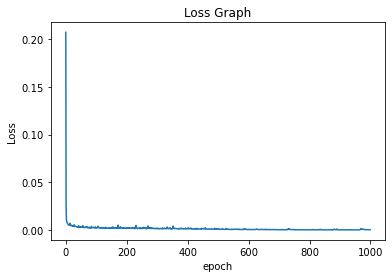

In [453]:
plt.plot(loss)
plt.title('Loss Graph')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

In [473]:
# given velocity and starting point, generate path based on starting point chosen
#  generate output path (len = 60), or generate input path(len=50)
def genPath(pathVel, startP):
    path = [startP]
#         print(len(path_w_seed))
    for i in range(len(pathVel)):
        path.append(np.array(path[i]) + np.array(pathVel[i][:2]))
    return np.array(path[1:])


# validate the predicted path and actual path
# returns the validation loss (MSE loss)
def validate(model, city):
    model.eval()
    predLoss = nn.MSELoss()
    totalacc = 0
    mseArr = []
#     get validate data & startPoints
    inpVal, oupVal = getVelData(city, 'val')
    inpStartVal, oupStartVal = getStart(city, 'val')
    
#     get true paths
    inpTruePath, oupTruePath = get_city_trajectories(city, 'val')
    
#     predict with velocityArr
    for i, velPath in enumerate(inpVal):
        res = model.predict(torch.Tensor(velPath).to(device), 60)
        predPath = genPath(res, oupStartVal[i])
        truePath = oupTruePath[i]
        acc = predLoss(torch.Tensor(predPath), torch.Tensor(truePath))
        totalacc += acc
        mseArr.append(acc)
        print("validating, ", i, "/", len(inpVal))
#     calculate average MSE loss
    totalacc /= len(inpVal)
    return totalacc, mseArr
    
# master trainer that auto processes data for corresponding city, trains and saves the loss array & model
# returns the model trained
def trainNSave(city, learning_rate, epochs, input_dim, hidden_dim, layer_count, output_dim, batch_size, target_len, training_prediction='mixed_teacher_forcing', teacher_forcing_ratio=0.6):
    
#     data processing for training
    inputs, outputs = getVelData(city, 'train')
    in_tensor = torch.swapaxes(torch.Tensor(inputs),0,1).to(device)
    out_tensor = torch.swapaxes(torch.Tensor(outputs),0,1).to(device)
    
#     train the model
    model = lstm_seq2seq(input_size = input_dim, hidden_size = hidden_dim).to(device)
    model.train()
    loss = model.train_model(in_tensor, out_tensor, n_epochs = epochs, target_len = target_len, batch_size = batch_size, training_prediction = training_prediction, teacher_forcing_ratio = teacher_forcing_ratio, learning_rate = learning_rate, dynamic_tf = False)

#     save trained model & lossArr
    torch.save(model.state_dict(), "./model/" + city + "_trained_lstm" + "_lr%s_epoch%d_hd%d_%s" % (str(learning_rate), epochs, hidden_dim, city))
    np.save("./lossArr/" + "trained_lstm" + "_lr%s_epoch%d_hd%d_%s" % (str(learning_rate), epochs, hidden_dim, city), loss)
    
    plt.plot(loss)
    plt.title('Loss Graph')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.show()
    
    return model
    

In [415]:
#     takes in the original data array
#     returns the velocity array as inputVel(x,y), starting from the 2nd step
def calcTestVel(dataArr):
    dataWV = []
    for path in np.array(dataArr):
        pathWV = []
#         get rid of the initial velocity
#         pathWV.append(path[1] - path[0])
        for coord in range(1, len(path)):
            changePos = path[coord] - path[coord-1]
#             Code for only velocity
            vel = path[coord] - path[coord-1]
            pathWV.append(vel)

#             Position change with actual velocity
#             posWithVel = np.concatenate((changePos, changePos*10))
#             pathWV.append(posWithVel)
    
        dataWV.append(pathWV)
    inp = []
    for path in dataWV:
        inp.append(path)
    return np.array(inp)

def getTestStart(city):
    
#     get test input, here oup = None
    inp, oup = get_city_trajectories(city, 'test')
    oupS= []
    for path in inp:
        oupS.append(path[49])
    return oupS

# give the model with dat for prediction, appends the data to csv
def test(model, city):
#     path to return, with predicted results
    outPaths = []
    
    model.eval()
#     get test input data, here output = none
    inp, oup = get_city_trajectories(city, 'test')
    oupStartVal = getTestStart(city)
#     get input velocity array
    inpVel = calcTestVel(inp)
    print(inpVel.shape)
    
#     predict with velocityArr
    for i, velPath in enumerate(inpVel):
        res = model.predict(torch.Tensor(velPath).to(device), 60)
        predPath = genPath(res, oupStartVal[i])
        if (i % 500 == 0 and i >= 500):
            print("predicting for ", city, ": ", i, "/", len(inpVel))
#         append the array to path
        outPaths.append(predPath)

    return outPaths

In [491]:
# Import writer class from csv module
import csv   

def getValStart(city):
    
#     get test input, here oup = None
    inp, oup = get_city_trajectories(city, 'val')
    oupS= []
    for path in inp:
        oupS.append(path[49])
    return oupS


# generates an array for all the predictions & write to csv
def genTest(model):
    
    for cityT in cities:
        model.load_state_dict(torch.load("./model/" + cityT + "_trained_lstm_lr0.0005_epoch1200_hd512_" + cityT))
#         model's prediction for the city
        out = test(model, cityT)
#     change the format into x,y,x,y,x,y
        flatOut = []
        for path in out:
            flatOut.append(np.array(path).flatten())
        
#         write to file
        with open('pred.csv', 'a+', newline='') as f:
            print("writing to file for city: ", cityT)
            writer = csv.writer(f)
            writer.writerows(flatOut)

            
# generates an validation array for all the cities
# returns two arrays, first is mse for each city, second is the detailed MSELoss Arr
def genValidation(model):
    accArr = []
    mseTotal = []
    
    for cityT in cities:
        model.load_state_dict(torch.load("./model/" + cityT + "_trained_lstm_lr0.0005_epoch1200_hd512_" + cityT))
#         model's prediction for the city
        acc, mseArr = validate(model, cityT)
        accArr.append(acc)
        mseTotal.append(mseArr)
    return accArr, mseTotal
            
# resacc, errArr = validate(model, 'austin')

In [486]:
abc = [[1,2],[2,3]]
abc = np.array(abc).flatten()
print(abc)

[1 2 2 3]


In [ ]:
accArr, mseTotal = genValidation(model)

validating,  0 / 34433
validating,  1 / 34433
validating,  2 / 34433
validating,  3 / 34433
validating,  4 / 34433
validating,  5 / 34433
validating,  6 / 34433
validating,  7 / 34433
validating,  8 / 34433
validating,  9 / 34433
validating,  10 / 34433
validating,  11 / 34433
validating,  12 / 34433
validating,  13 / 34433
validating,  14 / 34433
validating,  15 / 34433
validating,  16 / 34433
validating,  17 / 34433
validating,  18 / 34433
validating,  19 / 34433
validating,  20 / 34433
validating,  21 / 34433
validating,  22 / 34433
validating,  23 / 34433
validating,  24 / 34433
validating,  25 / 34433
validating,  26 / 34433
validating,  27 / 34433
validating,  28 / 34433
validating,  29 / 34433
validating,  30 / 34433
validating,  31 / 34433
validating,  32 / 34433
validating,  33 / 34433
validating,  34 / 34433
validating,  35 / 34433
validating,  36 / 34433
validating,  37 / 34433
validating,  38 / 34433
validating,  39 / 34433
validating,  40 / 34433
validating,  41 / 34433
va

In [489]:
print(accArr)

[tensor(37.6020), tensor(33.1207), tensor(34.8601), tensor(46.3723), tensor(37.6634), tensor(40.8871)]


In [493]:
genTest(model)

(6325, 49, 2)
predicting for  austin :  500 / 6325
predicting for  austin :  1000 / 6325
predicting for  austin :  1500 / 6325
predicting for  austin :  2000 / 6325
predicting for  austin :  2500 / 6325
predicting for  austin :  3000 / 6325
predicting for  austin :  3500 / 6325
predicting for  austin :  4000 / 6325
predicting for  austin :  4500 / 6325
predicting for  austin :  5000 / 6325
predicting for  austin :  5500 / 6325
predicting for  austin :  6000 / 6325
writing to file for city:  austin
(7971, 49, 2)
predicting for  miami :  500 / 7971
predicting for  miami :  1000 / 7971
predicting for  miami :  1500 / 7971
predicting for  miami :  2000 / 7971
predicting for  miami :  2500 / 7971
predicting for  miami :  3000 / 7971
predicting for  miami :  3500 / 7971
predicting for  miami :  4000 / 7971
predicting for  miami :  4500 / 7971
predicting for  miami :  5000 / 7971
predicting for  miami :  5500 / 7971
predicting for  miami :  6000 / 7971
predicting for  miami :  6500 / 7971
pre

In [ ]:

for cityT in cities:
        model.load_state_dict(torch.load("./model/" + cityT + "_trained_lstm_lr0.001_epoch1200_hd150_" + cityT))
#         model's prediction for the city
        out = test(model, cityT)

In [381]:
# get each path's starting point & prediction starting point
def getStart(city, split):
        # get train data
    inp, oup = get_city_trajectories(city=city, split=split, normalized=False)
    # get whole path to calculate velocity
    togetherArr = []
    for i in range(len(inp)):
        togetherData = np.concatenate((inp[i], oup[i]))
        togetherArr.append(togetherData)
    inpS = []
    oupS = []
    for path in togetherArr:
        inpS.append(path[0])
        oupS.append(path[49])
    return inpS, oupS

inpStart, oupStart = getStart(city, split)

In [388]:
def showPath(path, color='r'):
    tempX = []
    tempY = []
    for elem in path:
        tempX.append(elem[0])
        tempY.append(elem[1])
    plt.scatter(tempX,tempY, c=color)

(60, 2)
tensor(187.9499)


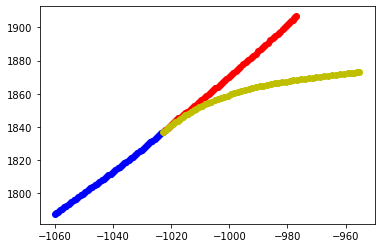

In [456]:


inpStartVal, oupStartVal = getStart(city, 'val')

# varName for Validation: inpVal, oupVal
# velocity array, begin symbol
res = model.predict(torch.Tensor(inpVal[120]).to(device), 60)
predPath = genPath(res, oupStartVal[120])
truePath = genPath(oupVal[120], oupStartVal[120])
pathStart = genPath(inpVal[120], inpStartVal[120])

print(predPath.shape)

predLoss = nn.MSELoss()
acc = predLoss(torch.Tensor(predPath), torch.Tensor(truePath))
print(acc)

showPath(predPath)
showPath(pathStart, 'b')
showPath(truePath, 'y')